A notebook for describing and demonstrating the learning of spectral parameter combination classifiers, for each spectral parameter combination.

# Overview

The goal of a 'spectral parameter combination classifier' is to find the linear combination of a pair of spectral parameters that best separates the labelled classes of the dataset, in that 2D spectral-parameter-pair-space, such that the spectral parameter combinations can then be ranked, according to a score of the class separation. 

Given constraints of the number of filters required to produce the spectral parameter pair, an 'optimal' spectral parameter combination can be selected by trading off the separation score against the number of required filters. The linear combination learned during the evaluation can then be used to classify unseen data into one of the pre-determined classes, using the required filters only. 

*Note how this is a different kind of dimension reduction to the traditional use of Principal Component Analysis (PCA), because here we are starting with only a subset of filters, and then performing the dimension reduction on this subset, whereas typically PCA starts with the complete set of spectral channels, and then reduces these.*

Previously, we evaluated all of the spectral parameters afforded by our example instrument over the example dataset.

Here, we will produce a list of spectral parameter pair combinations, and find the optimal linear combination that best separates the classes of the dataset by implementing Linear Discriminant Analysis.

Linear Discriminant Analysis is a standard tool in Machine Learning, but here we have implemented a bespoke implementation, so that the large number of spectral parameter pair combinations can be evaluated in parallel.

The Linear Discriminant Analysis naturally produces a measure of class separation, the 'Fisher Ratio'.

We have included in the software a method for investigating the validity of this, by splitting the dataset into a 'training' set, that is used to 'learn' the Linear Discriminant classifiers, and a 'test' set, that we treat as 'unseen' data to evaluate the accuracy of the classifiers.

Here, we demonstrate:
-  the pairing of spectral parameters, 
- the splitting of the dataset into 'test' and 'train' subsets, 
- parallel Linear Discriminant Anslysis on the 'train' dataset, 
- the evaluation of the classifier accuracy on the 'test' dataset, 
- and finally some tools for visualising the relationships between the Fisher Ratio and Accuracy metrics.

# Loading the Previously Defined Material Collection, Instrument and Observation

First we must re-load the previously evaluated spectral parameters.

In [2]:
from sptk.material_collection import MaterialCollection
from sptk.instrument import Instrument
from sptk.observation import Observation
from sptk.spectral_parameters import SpectralParameters

project_name = 'sptk_example'
MATERIAL_SET = {
    'Reds': [('synthetic_reds', '*'),
            ('mineral_reds', '*')],
    'Greens': [('synthetic_greens', '*')]}
spectral_library = 'example_spectral_library'
matcol = MaterialCollection(MATERIAL_SET,
            spectral_library,
            project_name,
            load_existing=True,
            plot_profiles=False)
inst = Instrument(
            name = 'example_instrument',
            project_name = 'sptk_example',
            load_existing=True)
obs = Observation(
        material_collection=matcol,
        instrument=inst,
        load_existing=True,
        plot_profiles=False)
sps = SpectralParameters(
        observation=obs,
        load_existing=True)

Loading existing sptk_example MaterialCollection DF
Exporting the Material Collection to CSV and Pickle formats...
Building Instrument...
Loading existing DataFrame for 'example_instrument'...
Loading existing Observation DataFrame...
Exporting the Observation Pickle format...
Observation export complete.
Loading existing Spectral Parameters DataFrame...
SpectralParameters export complete.


### Spectral Parameter Combinations

From the spectral parameter dataset, we then produce a list of combinations.

For each pair, we use LDA to find the linear combination of the 2 spectral
parameters that best separates the target from the background in the dataset.

We then check the accuracy of classification on each pair, and use this to
compare all the spectral parameter combinations.

We generate the combination list, and host the LDA classifier data, in a 
SpectralParameterCombinationClassifier (SPCC):

In [3]:
from sptk.spectral_parameter_combination_classifier import SpectralParameterCombinationClassifier as SPCC

The object is initialised by passing the spectral parameters dataset, and setting
the number of entries in each combination (k_combinations). Here we limit 
ourselves to 2 - i.e. pairs only.

In [4]:
spc = SPCC(
        spectral_parameters=sps,
        k_combinations=2,
        load_existing=False)

Building new SpectralParameterCombinationClassifier DataFrame for sptk_example


The SPCC object assigns an identifier to each spectral parameter combination (```spc_id```), and
stores the names of the component spectral parameters (```sp_0```, ```sp_1```), the instrument channels 
required to construct them (```fltrs_0```, ```fltrs_1```), and the number of unique filters (```n_uniq_fltrs```), and the unique filters themselves (```uniq_fltrs```) in a dataframe,
of the following format:

In [5]:
spc.main_df.head()

|   spc_id | sp_0   | sp_1   | fltrs_0   | fltrs_1   |   n_uniq_fltrs | uniq_fltrs                |
|---------:|:-------|:-------|:----------|:----------|---------------:|:--------------------------|
|        0 | R440   | R440   | F01       | F01       |              1 | frozenset({'F01'})        |
|        1 | R440   | R500   | F01       | F02       |              2 | frozenset({'F02', 'F01'}) |
|        2 | R440   | R580   | F01       | F03       |              2 | frozenset({'F03', 'F01'}) |
|        3 | R440   | R650   | F01       | F04       |              2 | frozenset({'F04', 'F01'}) |
|        4 | R440   | R780   | F01       | F05       |              2 | frozenset({'F05', 'F01'}) |

Here we only show a small number, the total number of spectral parameter 
combinations studied here, and contained in the dataframe, is:

In [6]:
len(spc.main_df)

20910

## Fitting the Linear Discriminant Classifiers

Now that we have prepared a list of spectral parameter combinations (SPCs), and we have evaluated all of the component spectral parameters, we are ready to perform Linear Discriminant Analysis on the SPCs.

The commonly used LDA toolkit provided by the Python library *scikit-learn* is not suitable for solving multiple LDA problems in parallel. For efficiency,
we have implemented a bespoke LDA algorithm, bench-marked against *scikit-learn*, that is capable of solving for all SPCs in parallel.

This process is run multiple times, handled by the 

```python
SPCC.fit_lda_repeat_holdout()
```
method, but here we will step through a single iteration for illustration.

We split the spectral parameters data into testing and training datasets:

In [7]:
train_sps, test_sps = sps.train_test_random_split(0.2, seed = 1)

and train the LDA classifiers on the training dataset:

In [8]:
lda_fits = spc.fit_lda(train_sps)

The fitting process performs the following steps on all spectral parameter combinations in paralllel:

 1. computes the within-class scatter matrix,
 2. computes the between-class scatter matrix,
 3. computes the projection matrix, by solving the generalised eigen-problem,
 4. computes the decision boundary on the projected data

The model parameters are appended to the list of spectral parameter combinations,
e.g.:

In [9]:
lda_fits.head()

|   spc_id |   lda_score |   lda_a_0_1 |   lda_a_1_1 |   lda_boundary_1 | lda_tg_gt_bg_1   |
|---------:|------------:|------------:|------------:|-----------------:|:-----------------|
|        0 |    0.175002 |    1        |    0        |         0.116536 | True             |
|        1 |    0.176367 |    0.907353 |    0.420369 |         0.16879  | True             |
|        2 |    0.589563 |    0.609319 |   -0.792925 |        -0.10362  | False            |
|        3 |    2.05087  |    0.565949 |   -0.824441 |        -0.155858 | False            |
|        4 |    2.5864   |    0.423039 |   -0.906111 |        -0.230999 | False            |

To illustrate the action of the learned Linear Discriminants, and the classifier, consider the top rated LDA score:

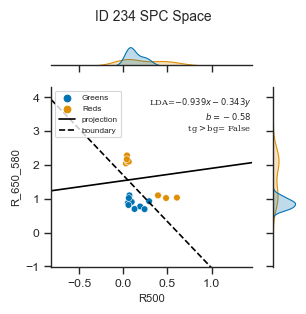

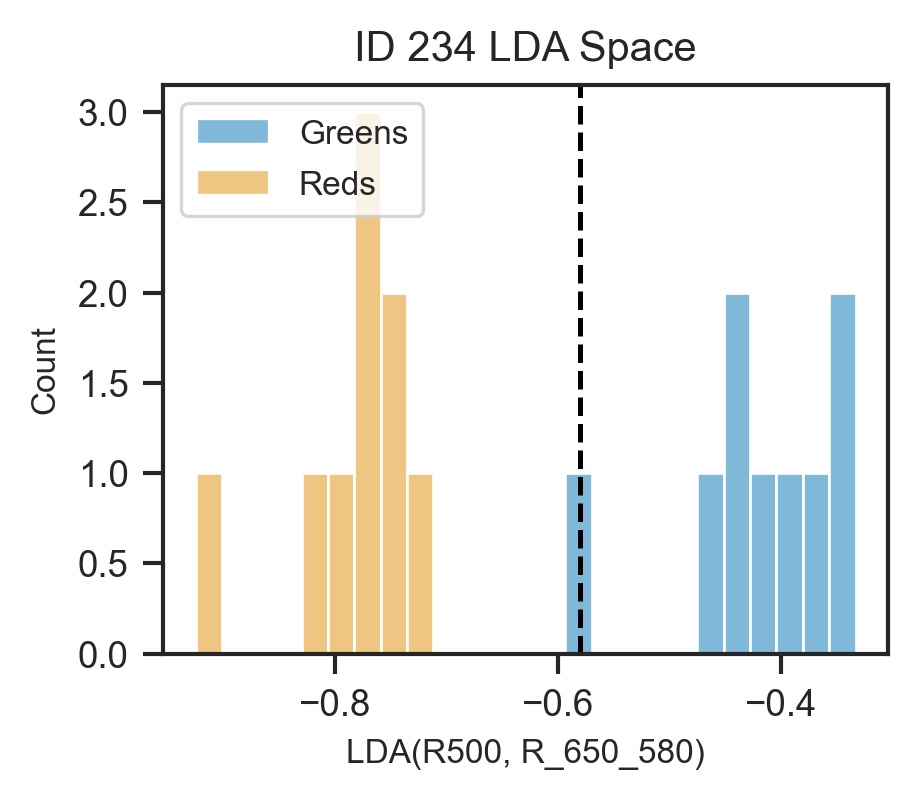

In [10]:
top_idx = lda_fits[lda_fits['lda_score'] == lda_fits['lda_score'].max()].index[0]
spc.plot_sp_combo(spc_id=top_idx, spectral_parameters=sps)
spc.plot_spc_lda(spc_id=top_idx, spectral_parameters=sps)

We see that the process has found a projection that maximises the separation between the means of the two categories, whilst minimising the variance within the two categories, and that a decision boundary has been found as the midpoint between the two inter-class means. Note also that the density plots for the individual spectral parameters have considerable overlap, but the the projection found has good separation.

## Classifier Accuracy

Then we make predictions on the test dataset using these learned classifiers.

We can illustrate this by demonstrating how the above example, of the top rated LDA score, performs on the testing data set in comparison to the training dataset used for the previous example:

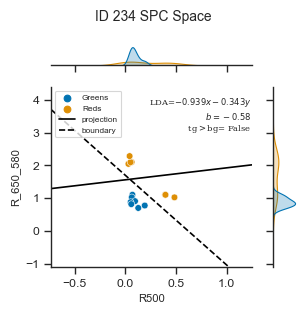

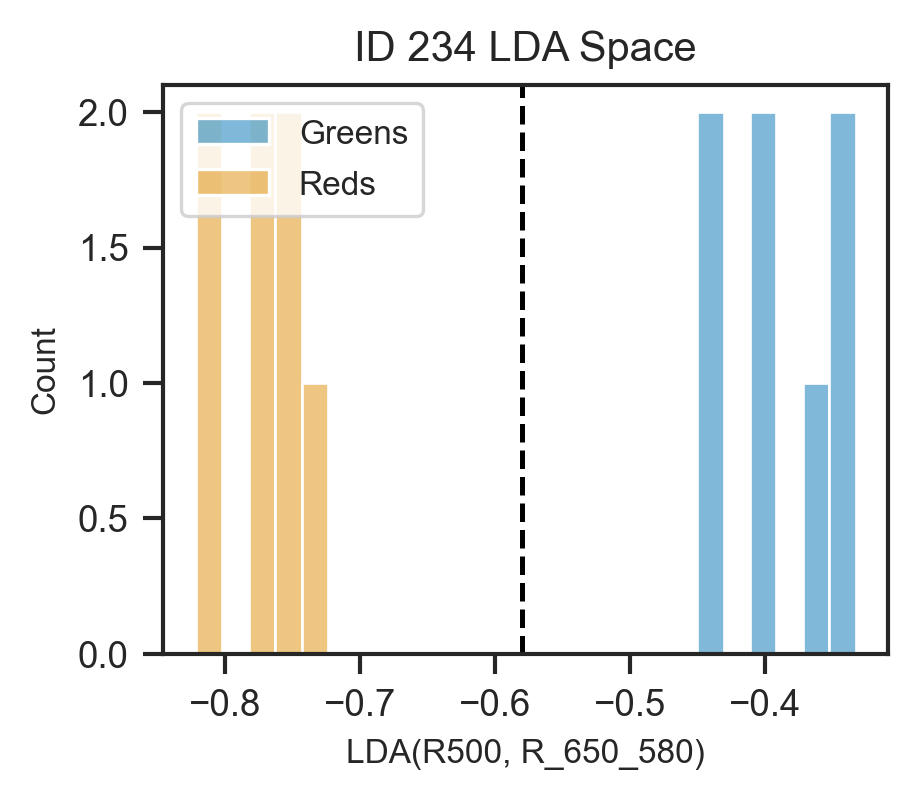

In [11]:
spc.plot_sp_combo(spc_id=top_idx, spectral_parameters=train_sps)
spc.plot_spc_lda(spc_id=top_idx, spectral_parameters=train_sps)

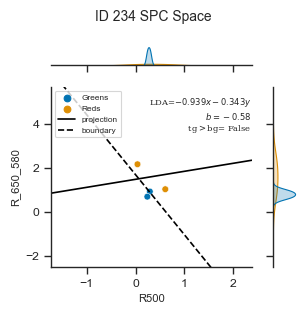

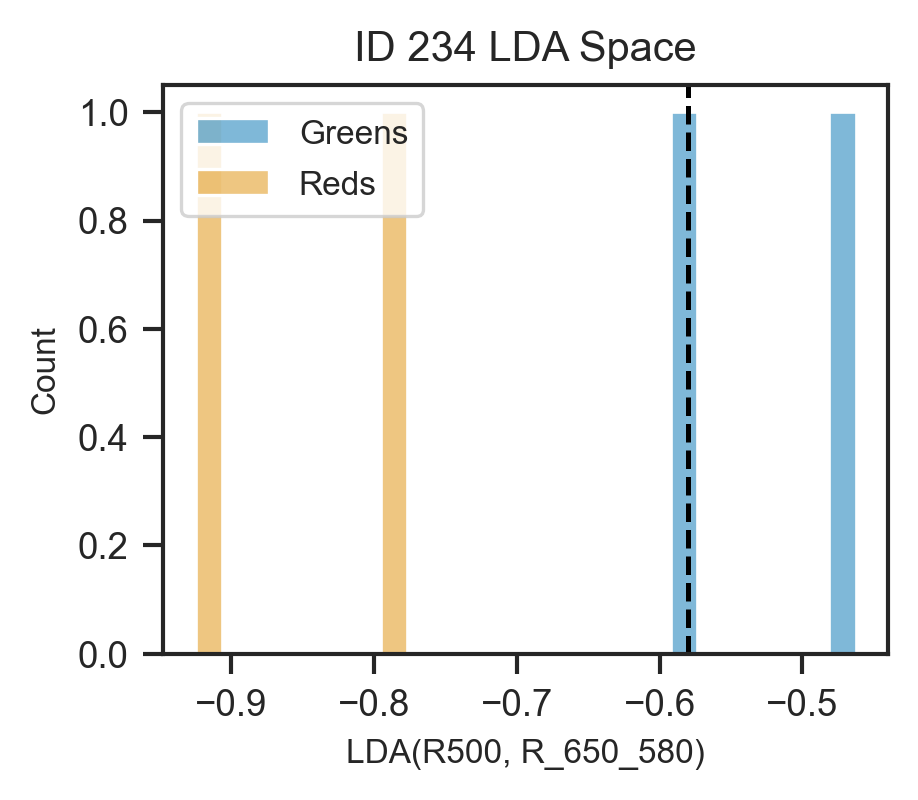

In [12]:
spc.plot_sp_combo(spc_id=top_idx, spectral_parameters=test_sps)
spc.plot_spc_lda(spc_id=top_idx, spectral_parameters=test_sps)

We see that there are several instances of misclassification now. In this process, we evaluate this misclassification for all of the spectral parameter combinations in parallel.

In [13]:
predictions = spc.binary_classifier(test_sps)

and then we test the accuracy of these predictions:

In [14]:
lda_acc = spc.binary_classifier_accuracy(predictions, test_sps.main_df.Category)

In [15]:
lda_acc.head()

|   spc_id |   lda_acc_1 |   lda_ppv_1 |   lda_tpr_1 |   lda_tnr_1 |   lda_fpr_1 |
|---------:|------------:|------------:|------------:|------------:|------------:|
|        0 |        0.25 |    0.333333 |         0.5 |         0   |         1   |
|        1 |        0.25 |    0.333333 |         0.5 |         0   |         1   |
|        2 |        0.5  |    0.5      |         0.5 |         0.5 |         0.5 |
|        3 |        1    |    1        |         1   |         1   |         0   |
|        4 |        0.75 |    0.666667 |         1   |         0.5 |         0.5 |

## Repeat Holdout Method

We repeat this process $k$ times, and aggregate the results of the LDA scores
and classification accuracy metrics, and also record the variance.

In [16]:
stats_df, trials_df = spc.fit_lda_repeat_holdout(sps, k_trials=100, export_df=False, load_existing=True)

Running trial 0 of 100...
Running trial 1 of 100...
Running trial 2 of 100...
Running trial 3 of 100...
Running trial 4 of 100...
Running trial 5 of 100...
Running trial 6 of 100...
Running trial 7 of 100...
Running trial 8 of 100...
Running trial 9 of 100...
Running trial 10 of 100...
Running trial 11 of 100...
Running trial 12 of 100...
Running trial 13 of 100...
Running trial 14 of 100...
Running trial 15 of 100...
Running trial 16 of 100...
Running trial 17 of 100...
Running trial 18 of 100...
Running trial 19 of 100...
Running trial 20 of 100...
Running trial 21 of 100...
Running trial 22 of 100...
Running trial 23 of 100...
Running trial 24 of 100...
Running trial 25 of 100...
Running trial 26 of 100...
Running trial 27 of 100...
Running trial 28 of 100...
Running trial 29 of 100...
Running trial 30 of 100...
Running trial 31 of 100...
Running trial 32 of 100...
Running trial 33 of 100...
Running trial 34 of 100...
Running trial 35 of 100...
Running trial 36 of 100...
Running tri

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:569: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  var_spc = trials_df.groupby(level='metric', axis=1).std()**2


SpectralParameterCombinationClassifier export complete.


The trials_df dataframe logs all of the results of the repeat trials, for example here we show the first 3 results of the Fisher Ratio and Accuracy scores:

In [17]:
exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]
exmpl_trials.head()

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_37971/1810775136.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]


metric lda_score                    
trial          1         2         3
spc_id                              
0       0.200570  0.122448  0.056855
1       0.202842  0.157604  0.059437
2       0.608287  0.409937  0.517387
3       2.317227  1.926071  2.252220
4       1.696222  1.155270  1.432170

In [18]:
exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]
exmpl_trials.head()

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_37971/1810775136.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]


metric lda_score                    
trial          1         2         3
spc_id                              
0       0.200570  0.122448  0.056855
1       0.202842  0.157604  0.059437
2       0.608287  0.409937  0.517387
3       2.317227  1.926071  2.252220
4       1.696222  1.155270  1.432170

and the stats_df logs the mean and variance of these across the repeat trials:

In [19]:
stats_df[['lda_score','lda_acc_1']].head()

metric lda_score           lda_acc_1          
            mean       var      mean       var
spc_id                                        
0       0.123173  0.006572    0.5825  0.042999
1       0.145584  0.006583    0.4925  0.034665
2       0.646162  0.247143    0.6600  0.036010
3       2.455989  0.921801    0.8750  0.024621
4       1.777411  0.508531    0.8125  0.029514

In [20]:
stats_df[['lda_score','lda_acc_1']].head()

metric lda_score           lda_acc_1          
            mean       var      mean       var
spc_id                                        
0       0.123173  0.006572    0.5825  0.042999
1       0.145584  0.006583    0.4925  0.034665
2       0.646162  0.247143    0.6600  0.036010
3       2.455989  0.921801    0.8750  0.024621
4       1.777411  0.508531    0.8125  0.029514

We save the outputs of the trials, and the statistical summaries:

In [21]:
# spc.export_df(df_type='trials')

In [22]:
spc.export_df(df_type='stats')

SpectralParameterCombinationClassifier export complete.


We then use the fit_lda function to fit the spectral parameter combination 
classifiers to the entire dataset, with division,

In [23]:
_ = spc.fit_lda(sps)

We also run the accuracy evaluation over the entire dataset:

In [24]:
predictions = spc.binary_classifier(sps)
lda_acc = spc.binary_classifier_accuracy(predictions, sps.main_df.Category, apply=True)

In [25]:
spc.main_df['lda_score'].head()

spc_id
0    0.109010
1    0.116670
2    0.503341
3    2.094796
4    1.493609
Name: lda_score, dtype: float64

In [26]:
spc.main_df['lda_acc_1'].head()

spc_id
0    0.611111
1    0.666667
2    0.722222
3    0.944444
4    0.888889
Name: lda_acc_1, dtype: float64

Finally, we rank the order of each of the metrics, according to the averages over repeat-holdout, and according to the results across the entire dataset:

In [27]:
_ = spc.rank_spcs(metric='lda_acc_1', scope='mean')
_ = spc.rank_spcs(metric='lda_score', scope='mean')
_ = spc.rank_spcs(metric='lda_acc_1', scope='all-data')
_ = spc.rank_spcs(metric='lda_score', scope='all-data')

This also computes the percentile of the ranks.

We export the complete set of results:

In [28]:
complete_df = spc.export_complete_df()

# Results

The table of results can be summarised as containing the following information:

For each of the Spectral Parameter Combinations, we have:
- Fitted a Linear Discriminant (a0: lda_a_0_1, a1: lda_a_1_1, b: lda_boundary_1, tg>bg:lda_tg_gt_bg_1)  
    Such that: $l = a_0p_0[x] + a_1p_1[x] - b$,  
    where $x \in \begin{cases} \text{target}\; \text{if}\; l > 0\; \text{and}\; \text{tg>bg} \; \text{or}\; l \leq 0\; \text{and}\; !\text{tg>bg} \;\\ \text{background}\; \text{otherwise} \end{cases}$  
    for entry $x$, for the spectral parameter combination composed of spectral parameters $0$ and $1$, that have values $p_0[x]$ and $p_1[x]$ for the entry $x$.
- Evaluated the mean Fisher Ratio and mean Accuracy, and associated variances, over 500 repeat trials of randomly split train and test data.
- Evaluated the Fisher Ratio and Accuracy over the entire dataset.

Here, we use these results to present:
1. The highest ranked Spectral Parameter Combinations when ranked by Mean Fisher Ratio and Mean Accuracy,
2. The highest ranked Spectral Parameter Combinations when ranked by Mean Fisher Ratio and Mean Accuracy, for a constrained number of unique constituent spectral filters,
3. Summaries of the performance of the population of spectral parameter combinations.

## Performance of Top Ranked SPCs on Complete Dataset

## Overall Top Ranked Spectral Parameter Combinations

Here are the Spectral Parameter Combinations that yield the highest mean Fisher Ratio and mean Accuracy scores after the repeat-holdout trials.

#### Rank by Mean Fisher Ratio

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:927: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = self.main_df[r_m_s].sort_values(


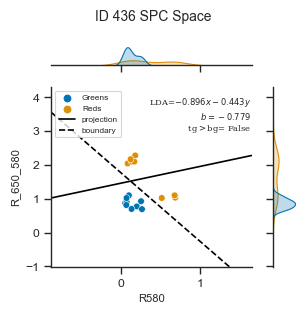

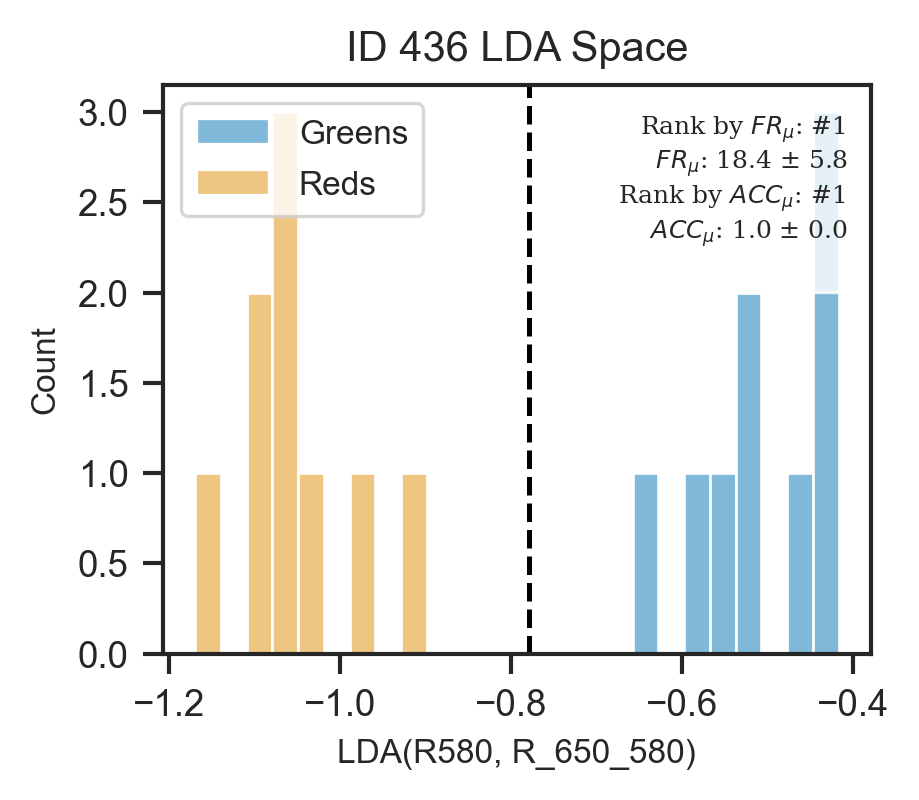

In [29]:
top_fr_spc_id, _ = spc.top_ranks(metric='lda_score', scope='mean', top_n=1, n_uniq_fltrs=None)
top_fr_stats, top_fr_sps = spc.plot_top_ranks(spectral_parameters=sps, metric='lda_score', top_n=1, n_uniq_fltrs=None, scope='mean')

In [30]:
top_fr_stats

metric rank_lda_score_mean  lda_score            rank_lda_acc_1_mean  \
                                 mean        var                       
spc_id                                                                 
436                    1.0  18.408832  33.939583                 1.0   

metric lda_acc_1       
            mean  var  
spc_id                 
436          1.0  0.0

In [31]:
top_fr_sps

,sp_0,sp_1,fltrs_0,fltrs_1,n_uniq_fltrs,uniq_fltrs,lda_a_0_1,lda_a_1_1,lda_boundary_1,lda_tg_gt_bg_1
spc_id,,,,,,,,,,
436,R580,R_650_580,F03,"F04, F03",2,"(F03, F04)",-0.896397,-0.443251,-0.779092,False


#### Rank by Mean Accuracy

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:927: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = self.main_df[r_m_s].sort_values(


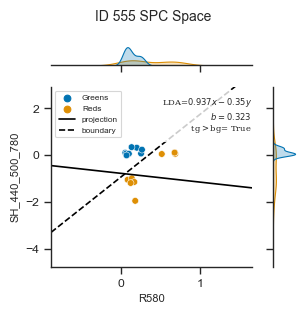

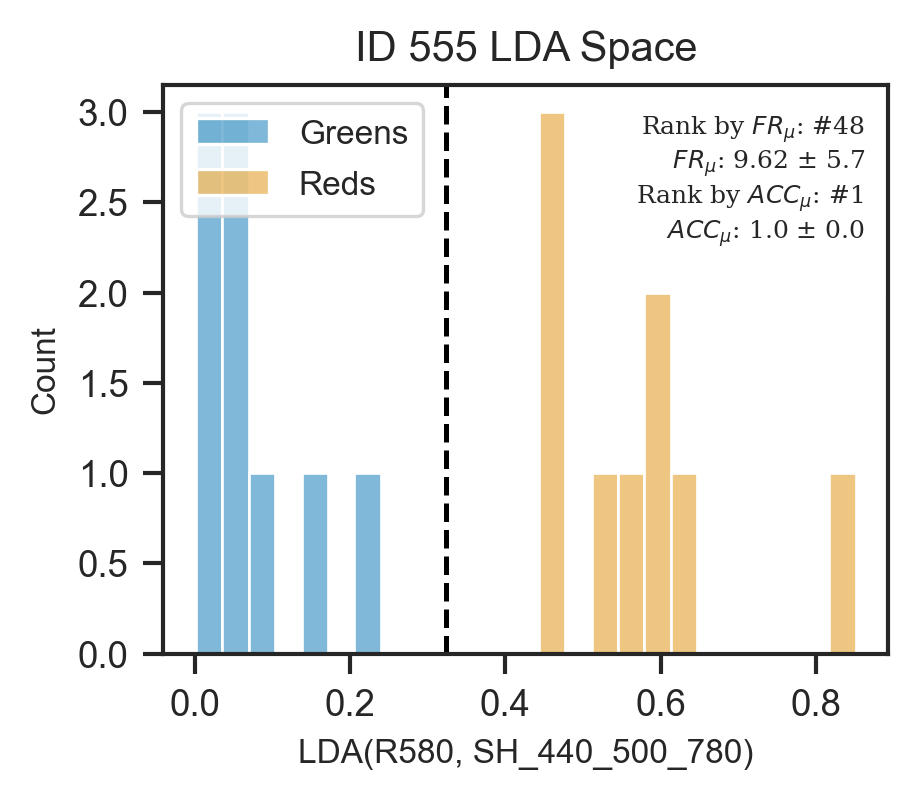

In [32]:
top_acc_spc_id, _ = spc.top_ranks(metric='lda_acc_1', scope='mean', top_n=1, n_uniq_fltrs=None)
top_acc_stats, top_acc_sps = spc.plot_top_ranks(spectral_parameters=sps, metric='lda_acc_1', top_n=1, n_uniq_fltrs=None, scope='mean')

In [33]:
top_acc_stats

metric rank_lda_score_mean lda_score            rank_lda_acc_1_mean lda_acc_1  \
                                mean        var                          mean   
spc_id                                                                          
555                   48.0  9.617496  32.635374                 1.0       1.0   

metric       
        var  
spc_id       
555     0.0

In [34]:
top_acc_sps

,sp_0,sp_1,fltrs_0,fltrs_1,n_uniq_fltrs,uniq_fltrs,lda_a_0_1,lda_a_1_1,lda_boundary_1,lda_tg_gt_bg_1
spc_id,,,,,,,,,,
555,R580,SH_440_500_780,F03,"F01, F02, F05",4,"(F03, F02, F01, F05)",0.936644,-0.350282,0.323455,True


## Top-ranked Spectral Parameter Combinations for each Number of Unique Filter Channels

We now consider the top-ranked spectral parameter combinations when the number of unique filters used to make up the spectral parameter combination (Number of Unique Channels - **NUC**) is restricted.

In [35]:
import pandas as pd

In [36]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'mean'
top_fr_mu = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [37]:
top_fr_mu

,lda_score,n_uniq_fltrs,uniq_fltrs,sp_0,sp_1,pct_lda_score,scope
spc_id,,,,,,,
609,1.345400,1,(F04),R650,R650,49.325681,$FR_{\mu}$
436,18.408832,2,"(F03, F04)",R580,R_650_580,100.000000,$FR_{\mu}$
559,17.180732,3,"(F03, F04, F01)",R580,SH_440_580_650,99.995218,$FR_{\mu}$
498,14.531617,4,"(F03, F02, F04, F01)",R580,BD_440_500_650,99.966523,$FR_{\mu}$
11107,5.122155,5,"(F03, F01, F08, F04, F02)",S_440_500,BD_580_650_1000,98.689622,$FR_{\mu}$
16648,4.807592,6,"(F03, F05, F01, F08, F07, F04)",BD_440_950_1000,BD_580_650_780,98.493544,$FR_{\mu}$


In [38]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'all-data'
top_fr_d = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [39]:
top_fr_d

,lda_score,n_uniq_fltrs,uniq_fltrs,sp_0,sp_1,pct_lda_score,scope
spc_id,,,,,,,
609,1.276727,1,(F04),R650,R650,54.079388,$FR_{D}$
436,15.862124,2,"(F03, F04)",R580,R_650_580,100.000000,$FR_{D}$
559,15.092245,3,"(F03, F04, F01)",R580,SH_440_580_650,99.995218,$FR_{D}$
498,13.154746,4,"(F03, F02, F04, F01)",R580,BD_440_500_650,99.976088,$FR_{D}$
20672,4.324686,5,"(F08, F07, F04, F06, F02)",SH_500_850_1000,SH_650_850_950,98.684840,$FR_{D}$
16648,4.240256,6,"(F03, F05, F01, F08, F07, F04)",BD_440_950_1000,BD_580_650_780,98.622669,$FR_{D}$


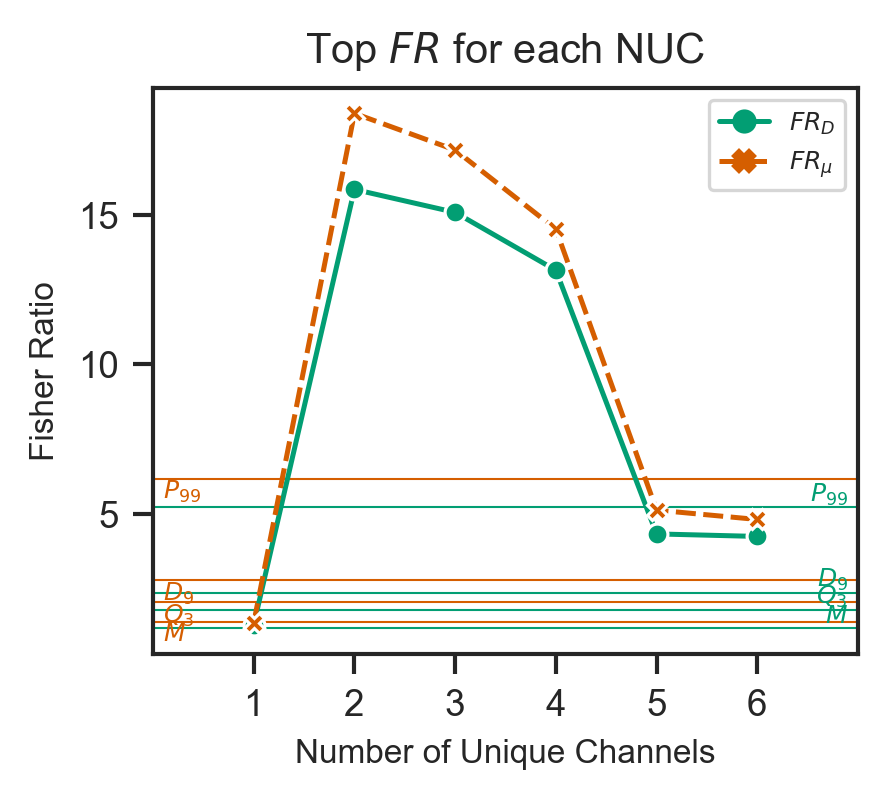

In [40]:
top_metric = pd.concat([top_fr_d, top_fr_mu])
spc.plot_top_metric_per_nuc(top_metric, metric='lda_score')

Similarly, we can plot the mean and all-data top Accuracy scores for each NUC:

In [41]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'mean'
top_acc_mu = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [42]:
top_acc_mu

,lda_acc_1,n_uniq_fltrs,uniq_fltrs,sp_0,sp_1,pct_lda_acc_1,scope
spc_id,,,,,,,
609,0.8350,1,(F04),R650,R650,69.626973,$ACC_{\mu}$
436,1.0000,2,"(F03, F04)",R580,R_650_580,100.000000,$ACC_{\mu}$
16,1.0000,3,"(F03, F02, F01)",R440,R_500_580,100.000000,$ACC_{\mu}$
702,1.0000,4,"(F02, F04, F01, F07)",R650,BD_440_500_950,100.000000,$ACC_{\mu}$
16707,0.9975,5,"(F03, F01, F08, F07, F04)",BD_440_950_1000,SH_580_650_1000,99.206121,$ACC_{\mu}$
16612,1.0000,6,"(F03, F05, F01, F08, F04, F06)",BD_440_850_1000,SH_580_650_780,100.000000,$ACC_{\mu}$


In [43]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'all-data'
top_acc_d = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [44]:
top_acc_d

,lda_acc_1,n_uniq_fltrs,uniq_fltrs,sp_0,sp_1,pct_lda_acc_1,scope
spc_id,,,,,,,
609,0.833333,1,(F04),R650,R650,56.771879,$ACC_{D}$
57,1.000000,2,"(F08, F01)",R440,R_1000_440,100.000000,$ACC_{D}$
16,1.000000,3,"(F03, F02, F01)",R440,R_500_580,100.000000,$ACC_{D}$
18501,1.000000,4,"(F06, F03, F04, F07)",BD_580_850_950,BD_650_850_950,100.000000,$ACC_{D}$
15433,1.000000,5,"(F03, F05, F01, F08, F04)",BD_440_580_780,SH_580_650_1000,100.000000,$ACC_{D}$
15792,1.000000,6,"(F03, F05, F01, F08, F04, F06)",BD_440_650_780,BD_580_850_1000,100.000000,$ACC_{D}$


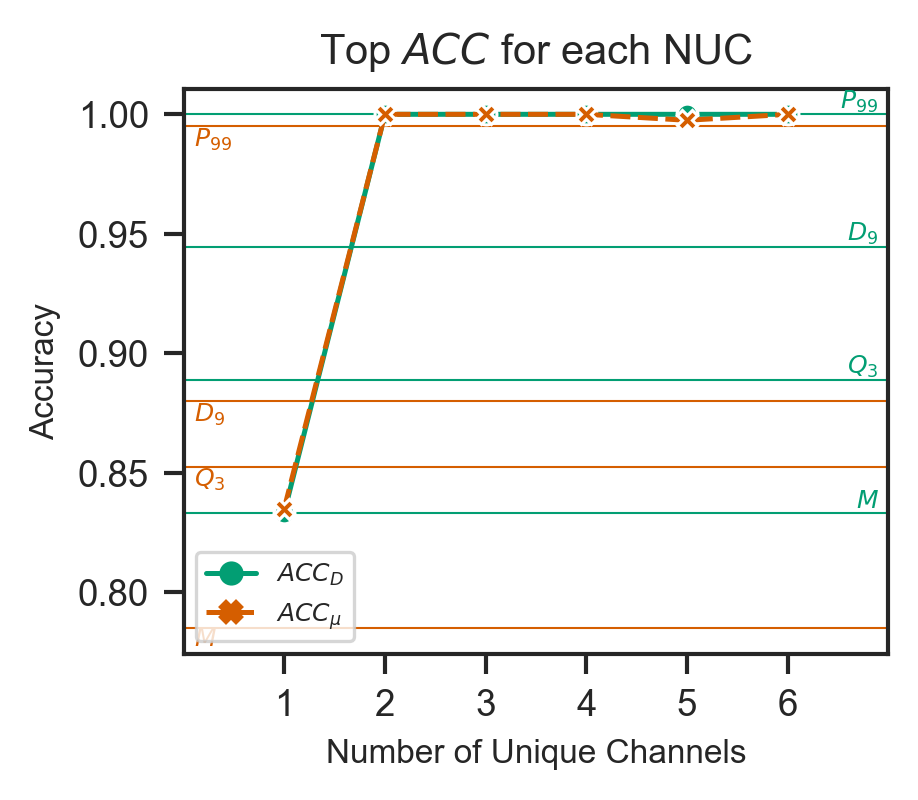

In [45]:
top_metric = pd.concat([top_acc_d, top_acc_mu])
spc.plot_top_metric_per_nuc(top_metric, metric='lda_acc_1')

Note that when ranking the spectral parameters, we found that in some cases there were multiple equal entries. To log these, we can run the ```top_spc_per_nuc``` function again, with ```count_equals``` set to true:

Data for Top SPCs ranked by Mean Accuracy:

In [46]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'mean'
top_acc_mu = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


Data for Top SPCs ranked by All-Data Accuracy:

In [47]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'all-data'
top_acc_d = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


Data for Top SPCs ranked by Mean Fisher Ratio:

In [48]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'mean'
top_fr_mu = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


Data for Top SPCs ranked by All-Data Fisher Ratio:

In [49]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'all-data'
top_fr_d = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


## Spectral Parameter Combination Population Performance

We now produce visualisations of the performance of all of the spectral parameter combinations evaluated, to show insight into the method.

### Reciever Operating Characteristic

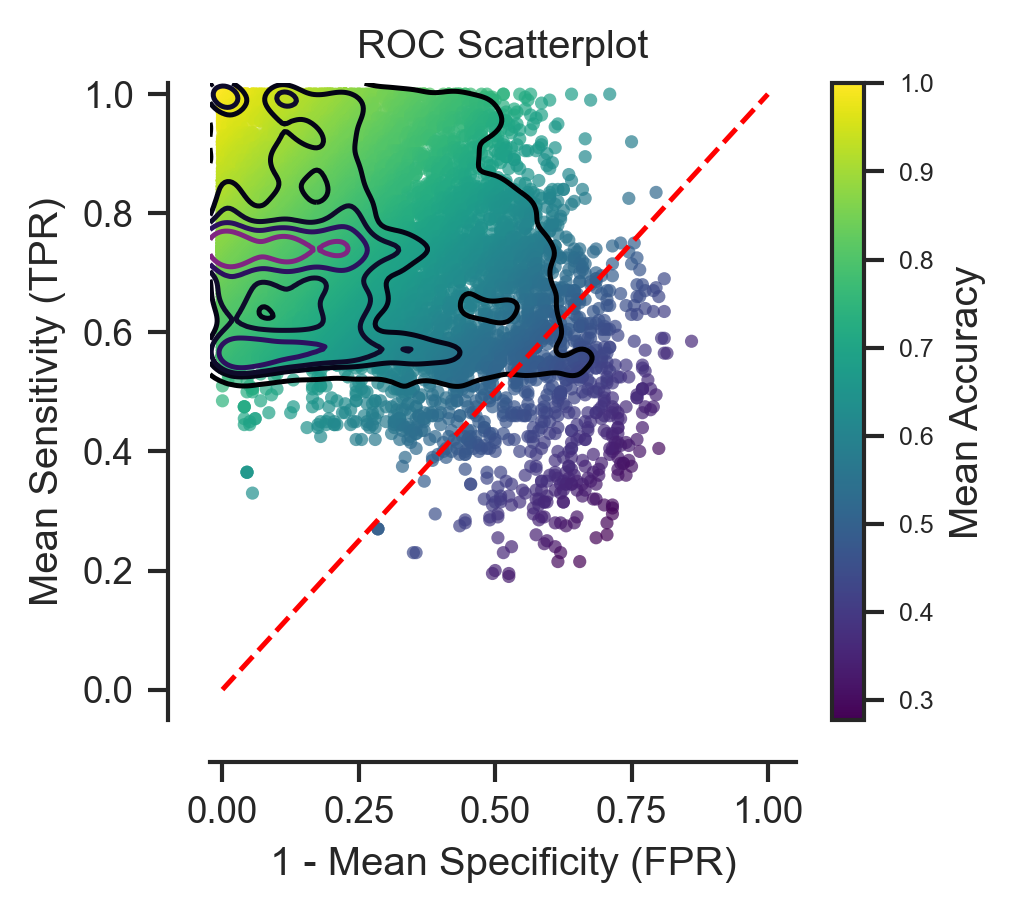

In [50]:
spc.plot_roc(noisey=False)

### Uni- and Bi-variate Distributions of Mean Fisher Ratio and Mean Classification Accuracy

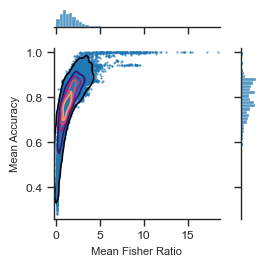

In [51]:
spc.plot_metric_vs_metric(
                ('lda_score', 'Mean Fisher Ratio'),
                ('lda_acc_1', 'Mean Accuracy'))

### All-Data Metrics vs. Repeat-Holdout Mean Metrics

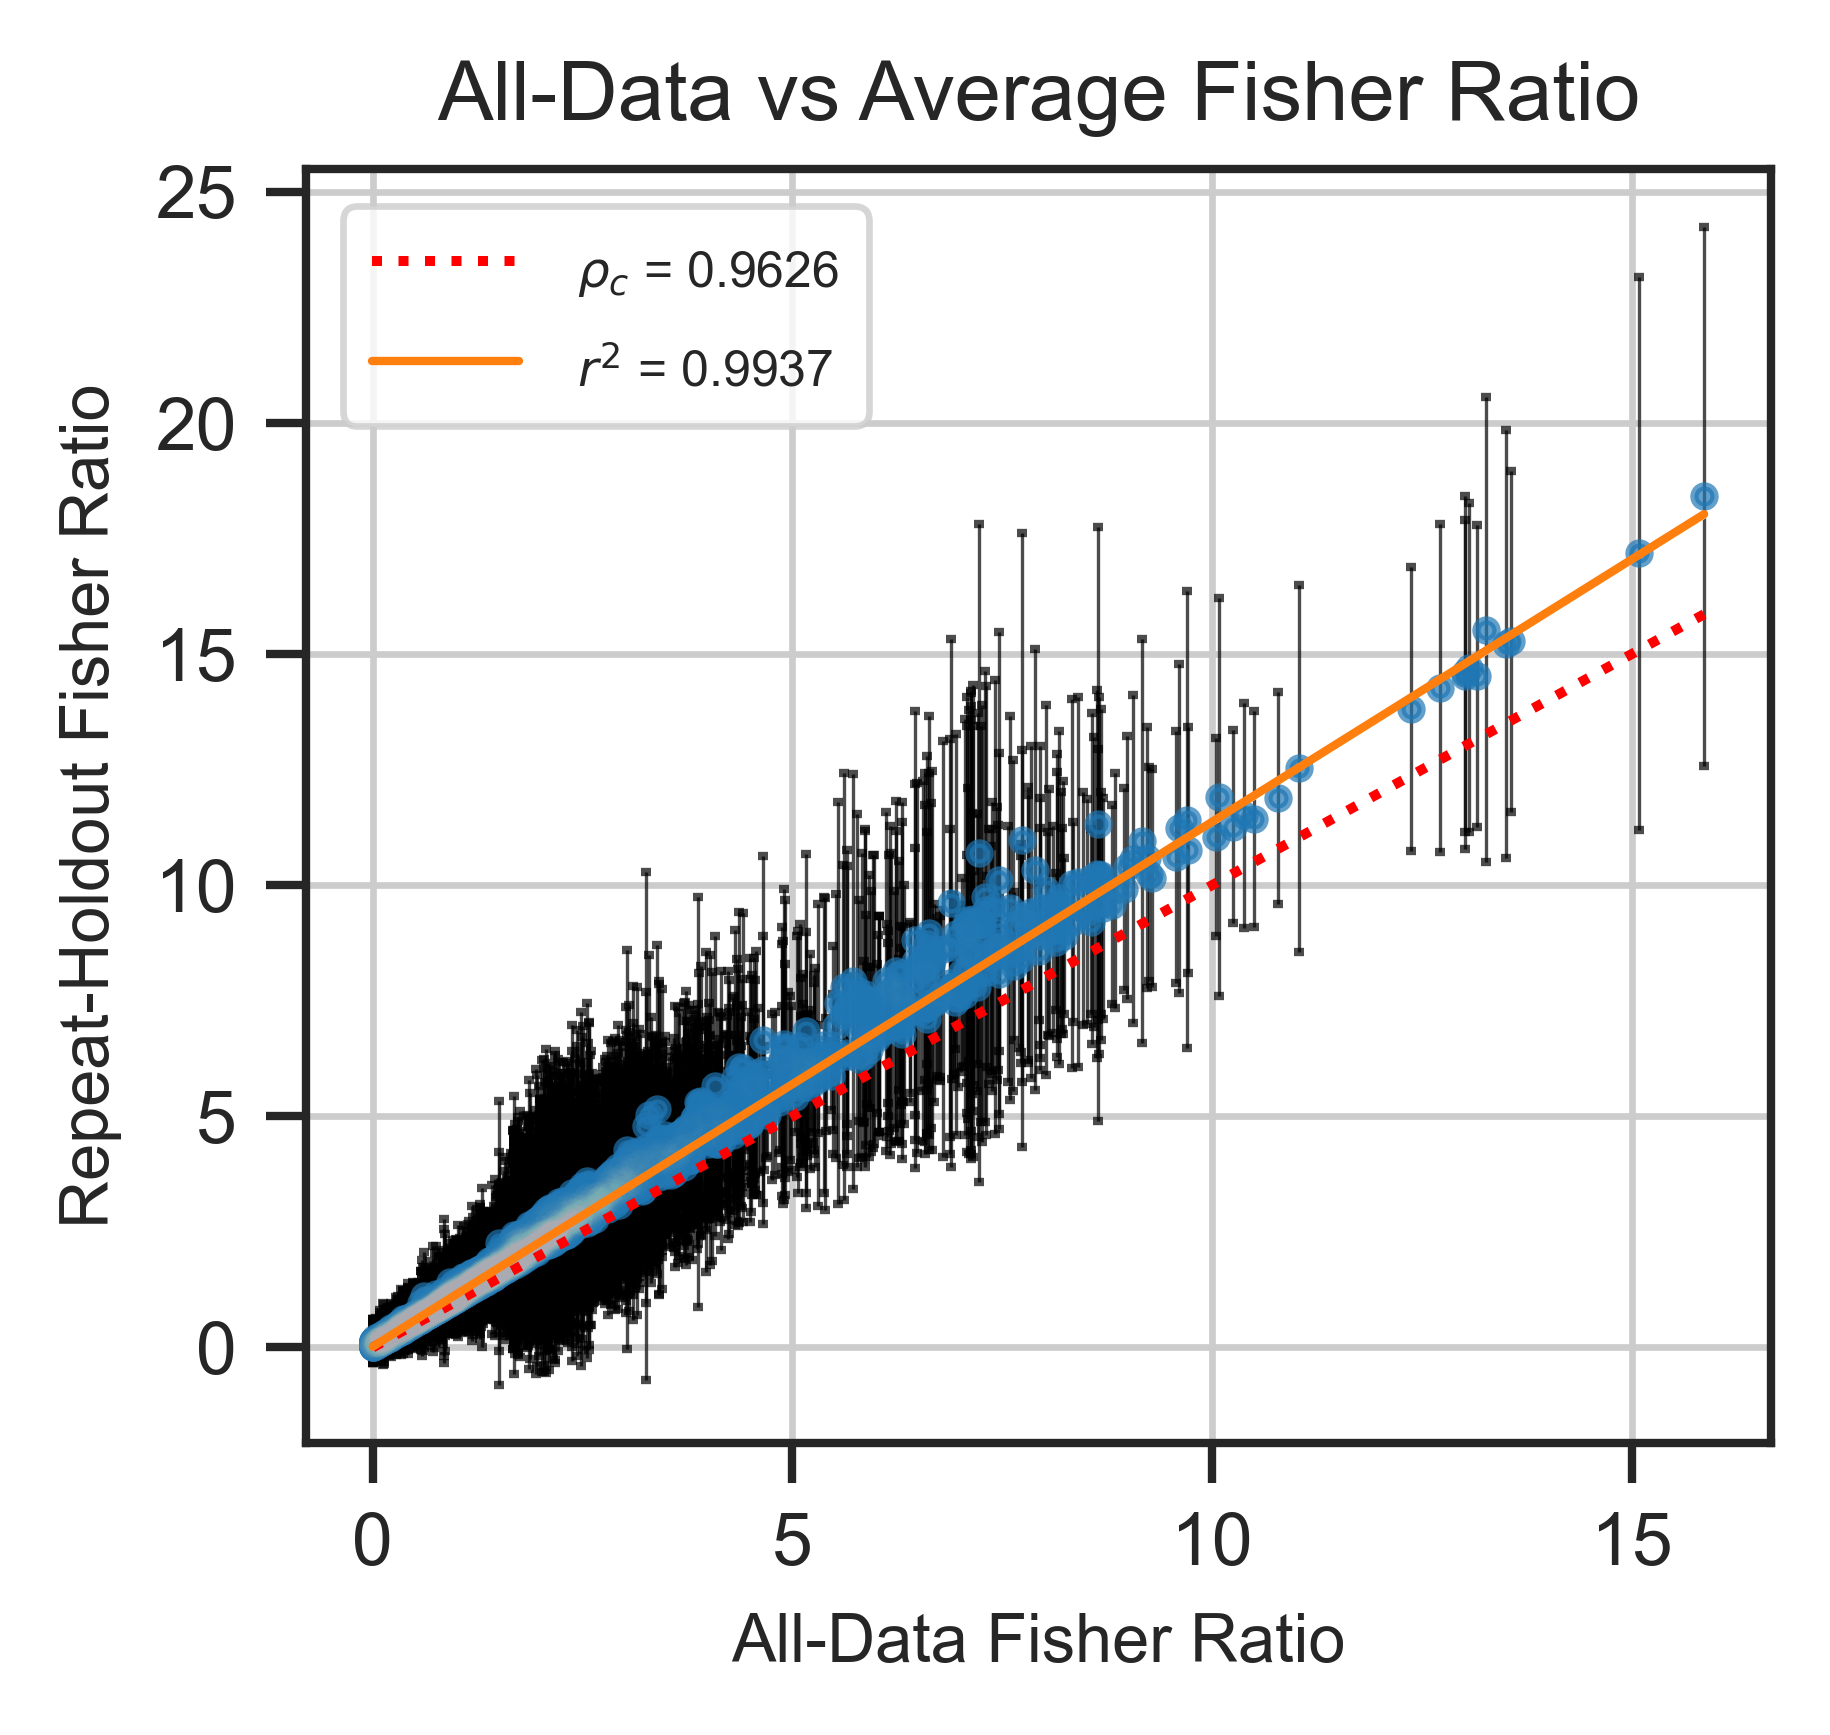

In [52]:
fr_fit = spc.plot_lda_score_stats()

In [53]:
print(fr_fit)

{'r^2': 0.9937160423914376, 'ccc': 0.9625739067419494}


/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:1983: RuntimeWarning: divide by zero encountered in divide
  weights = 1/y_err.to_numpy()[p_sm]


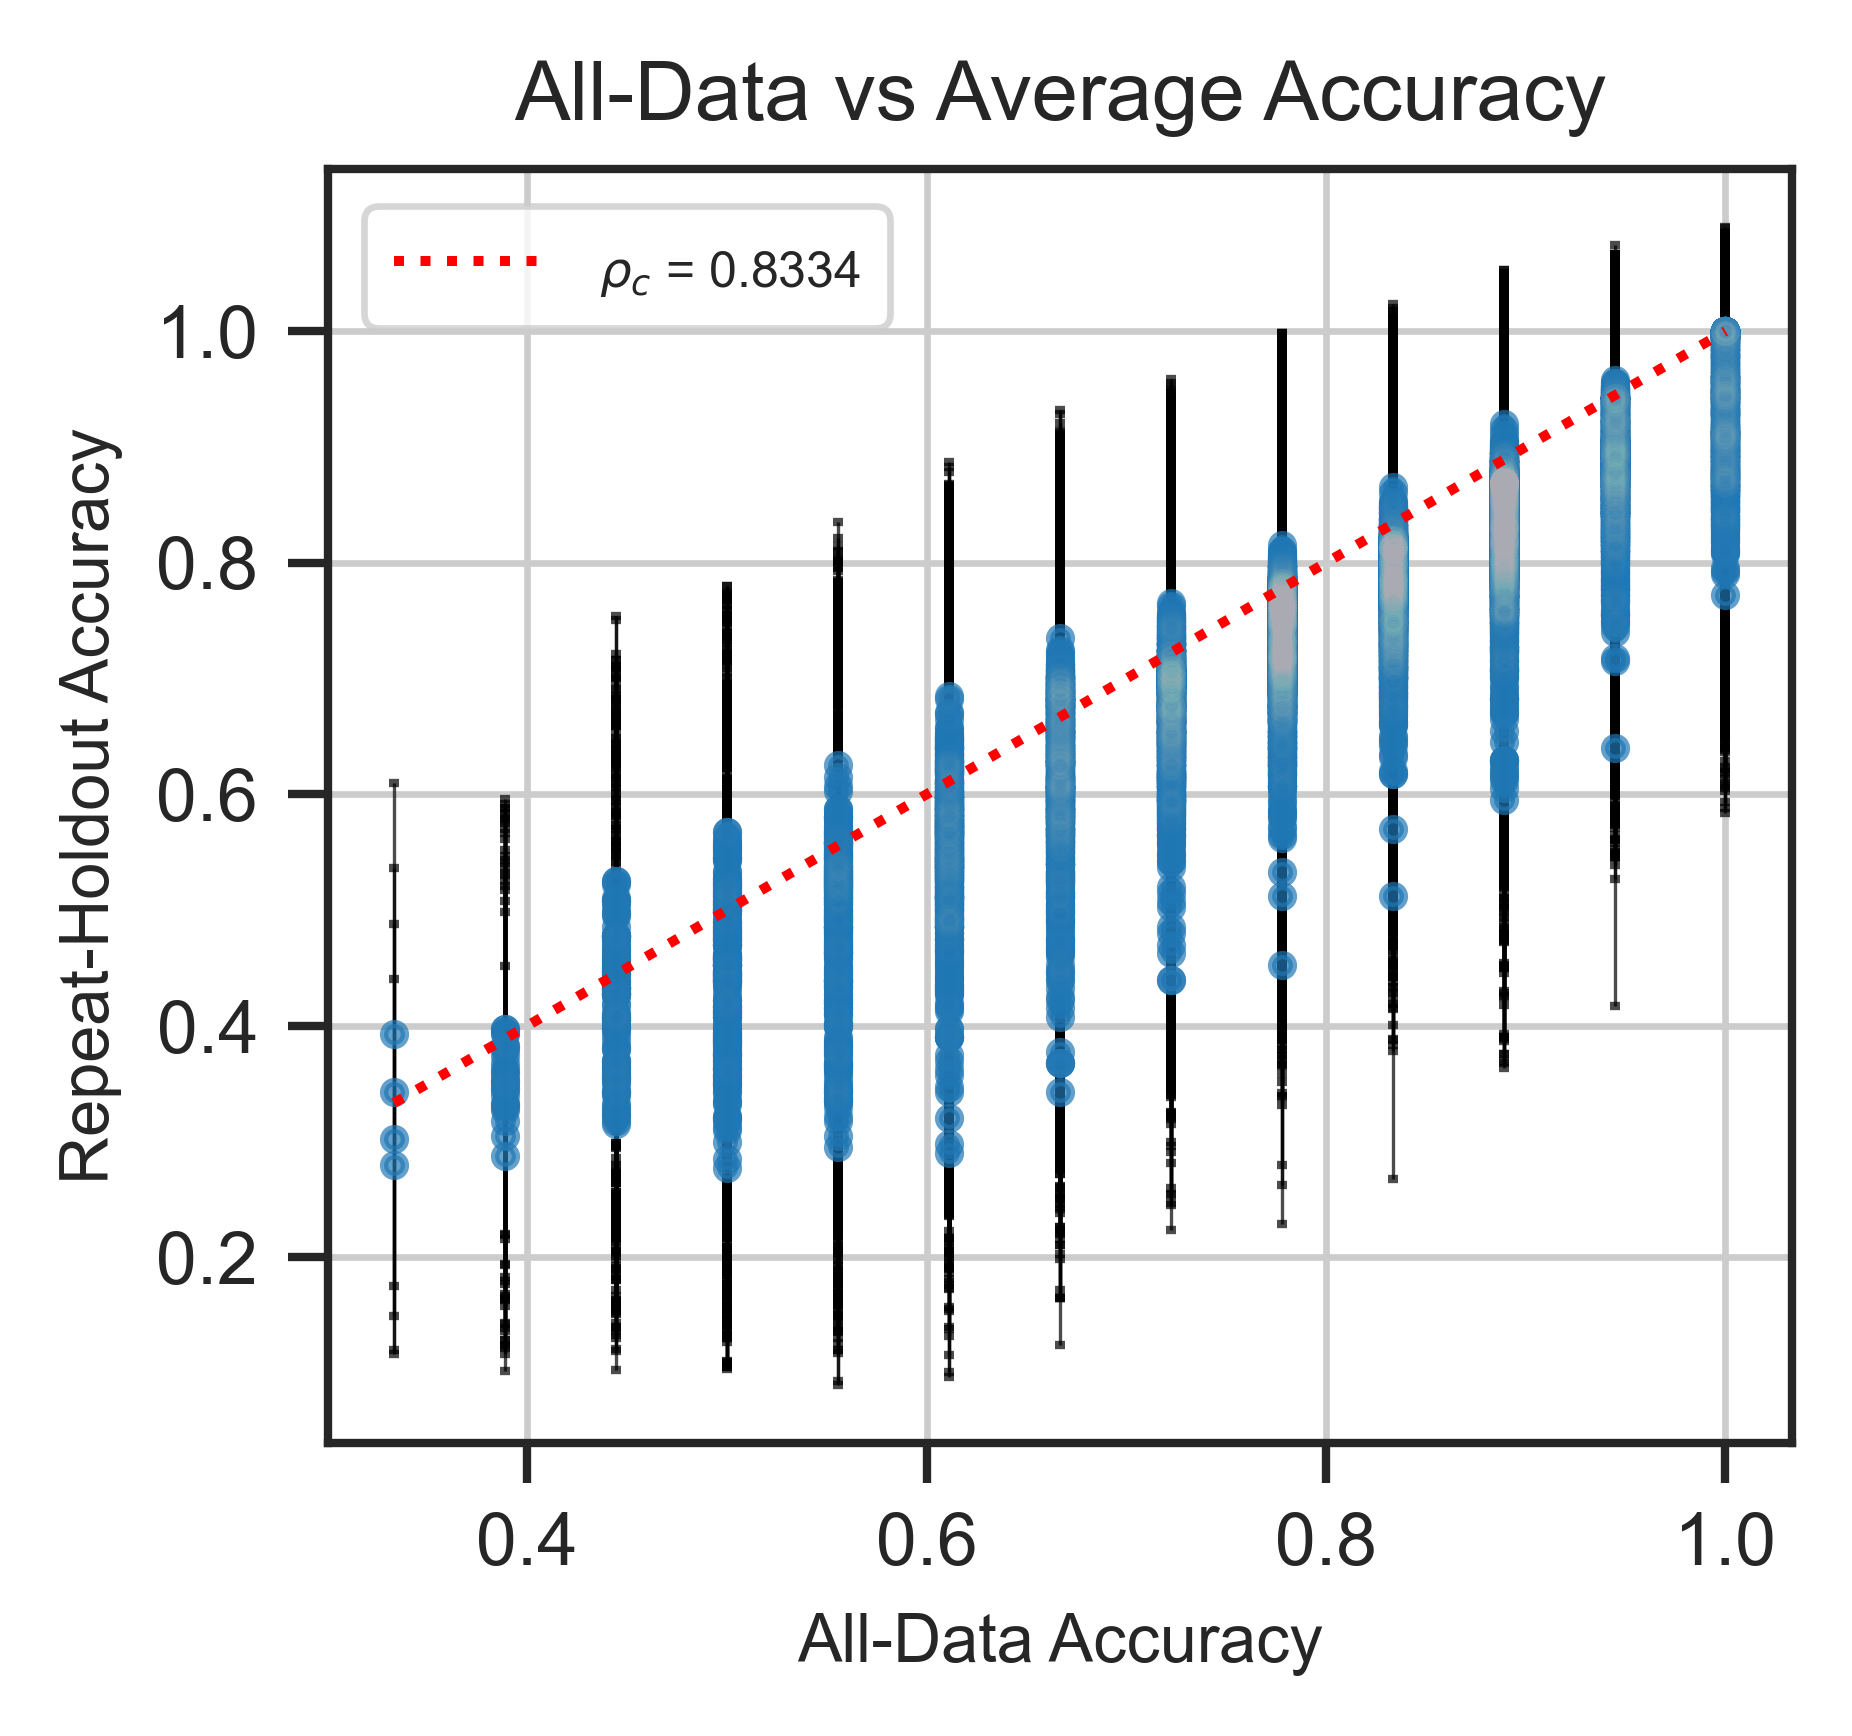

In [54]:
acc_fit = spc.plot_accuracy_stats(lda_acc)

In [55]:
print(acc_fit)

{'r^2': None, 'ccc': 0.833399657634669}


### Mean vs. Coefficient-of-Variation Analysis of Fisher Ratio and Classification Accuracy

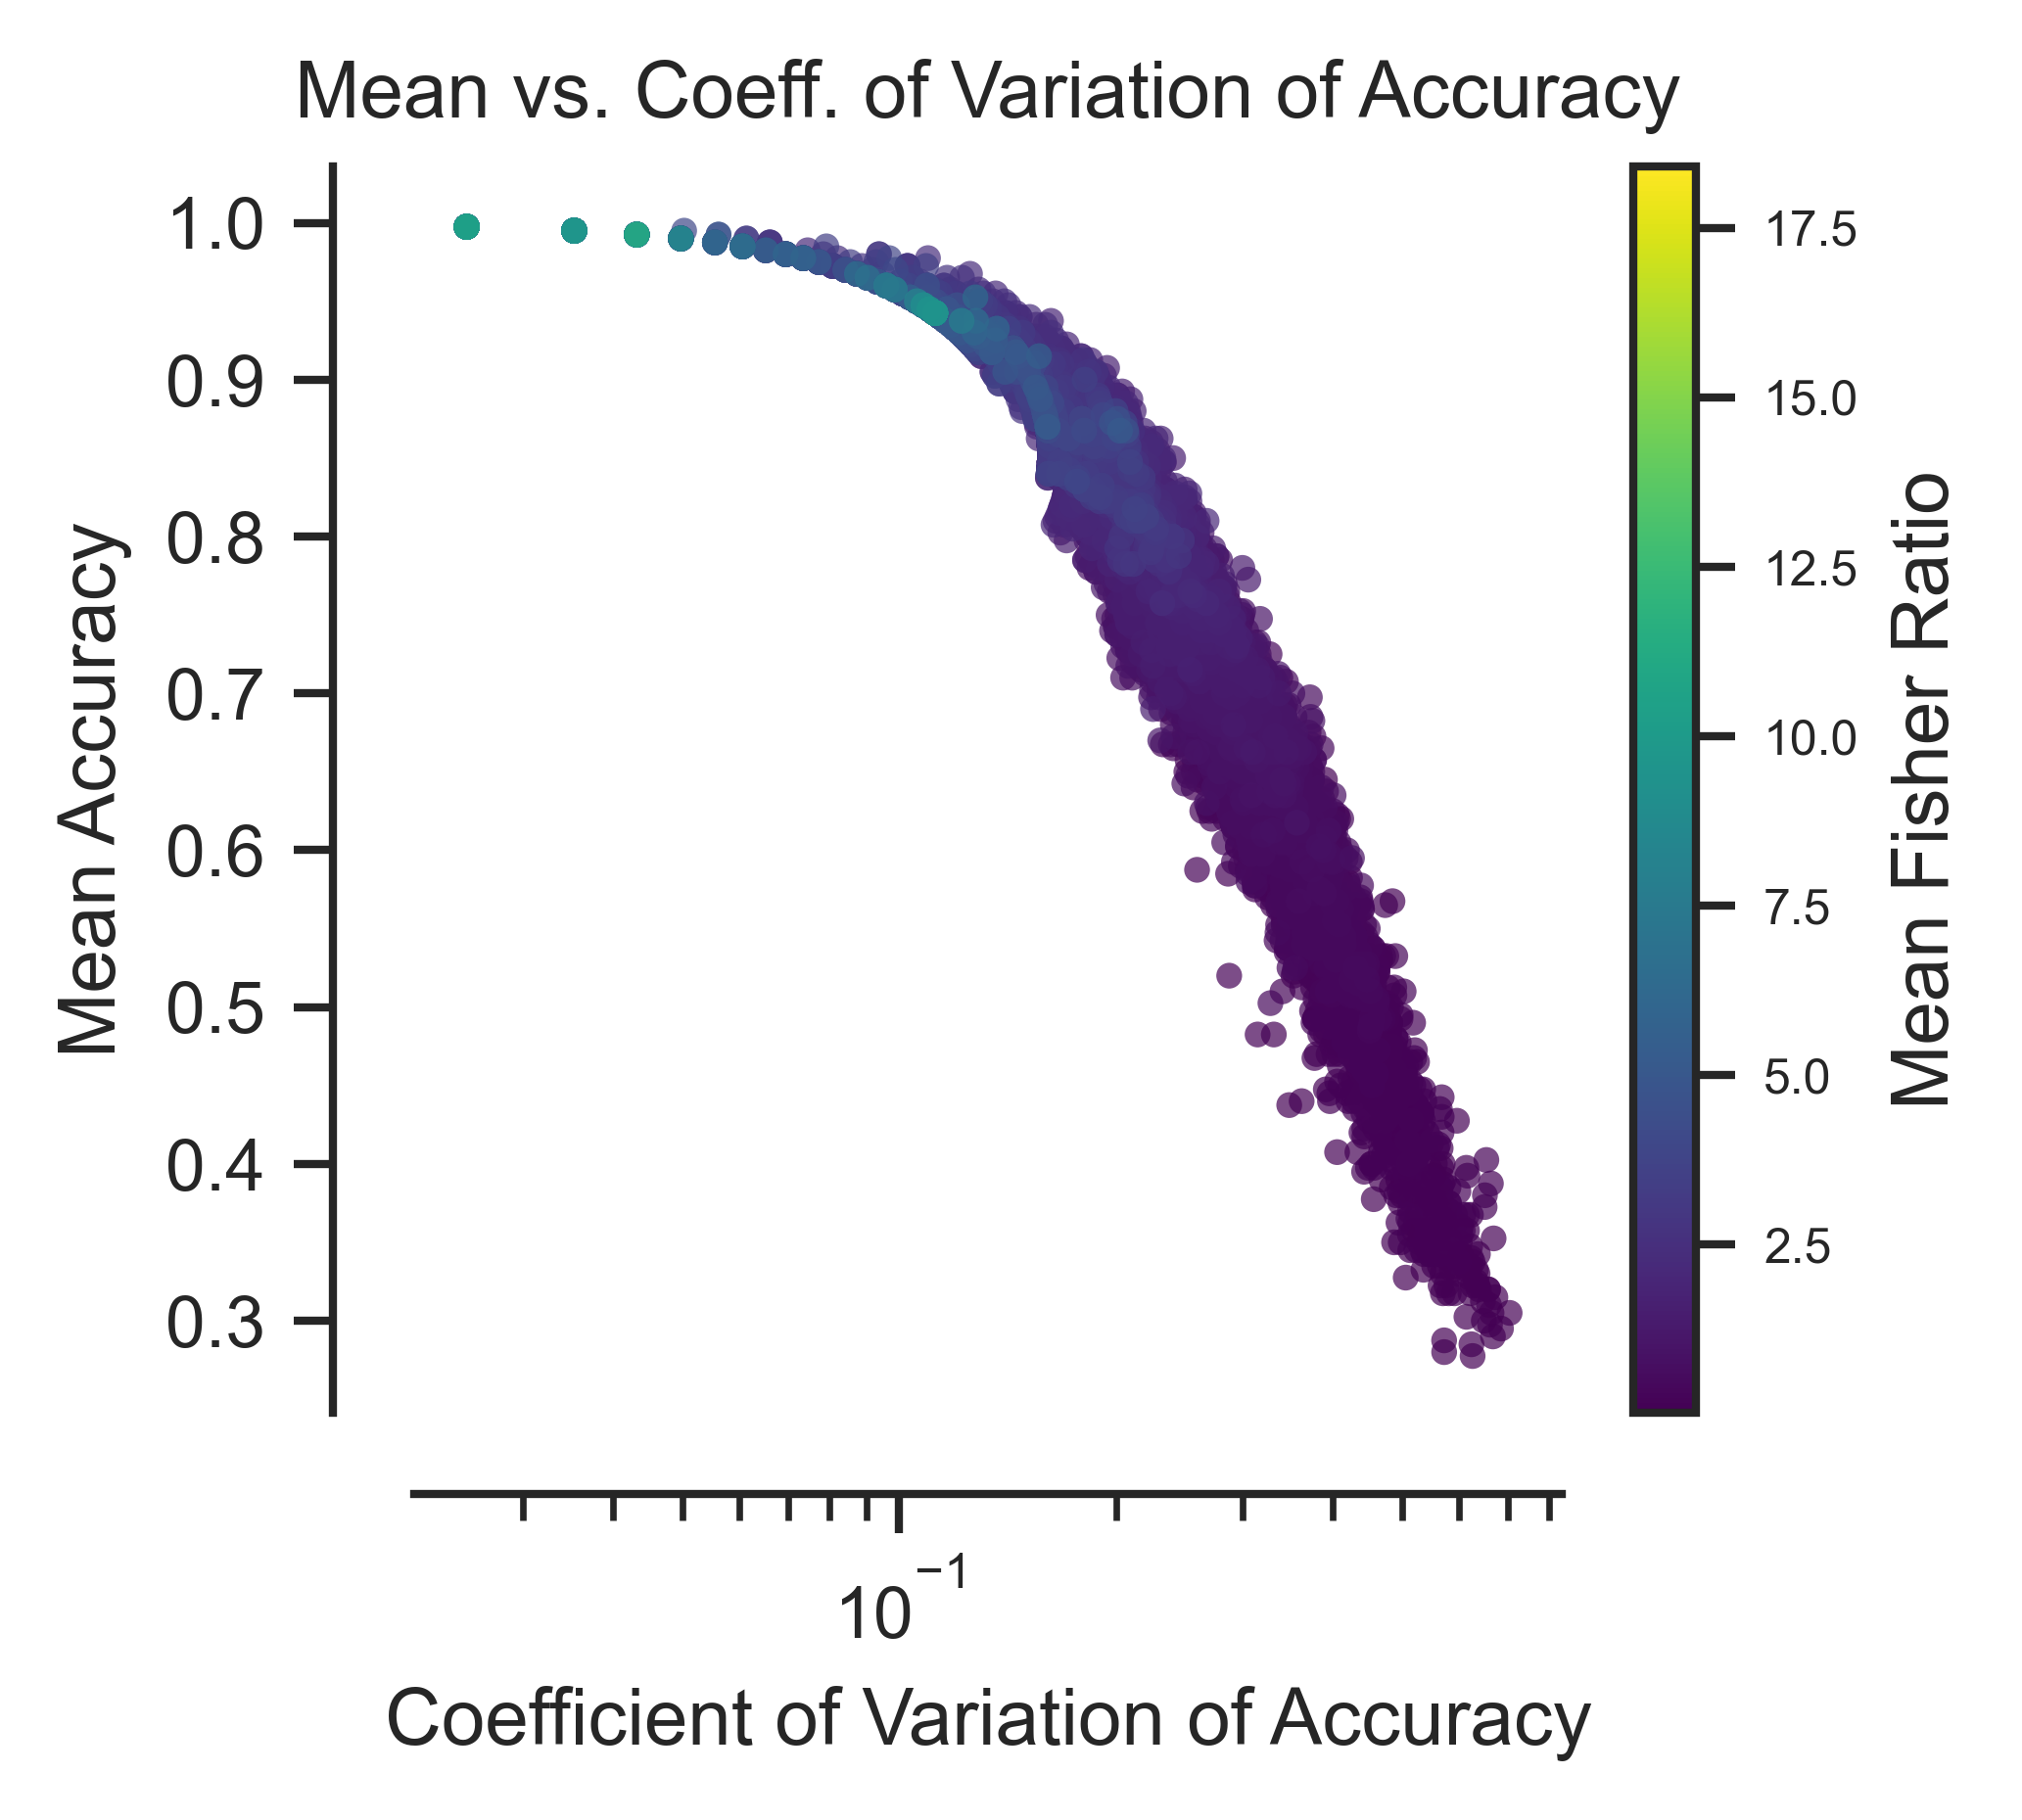

In [56]:
spc.plot_mean_cv('accuracy')

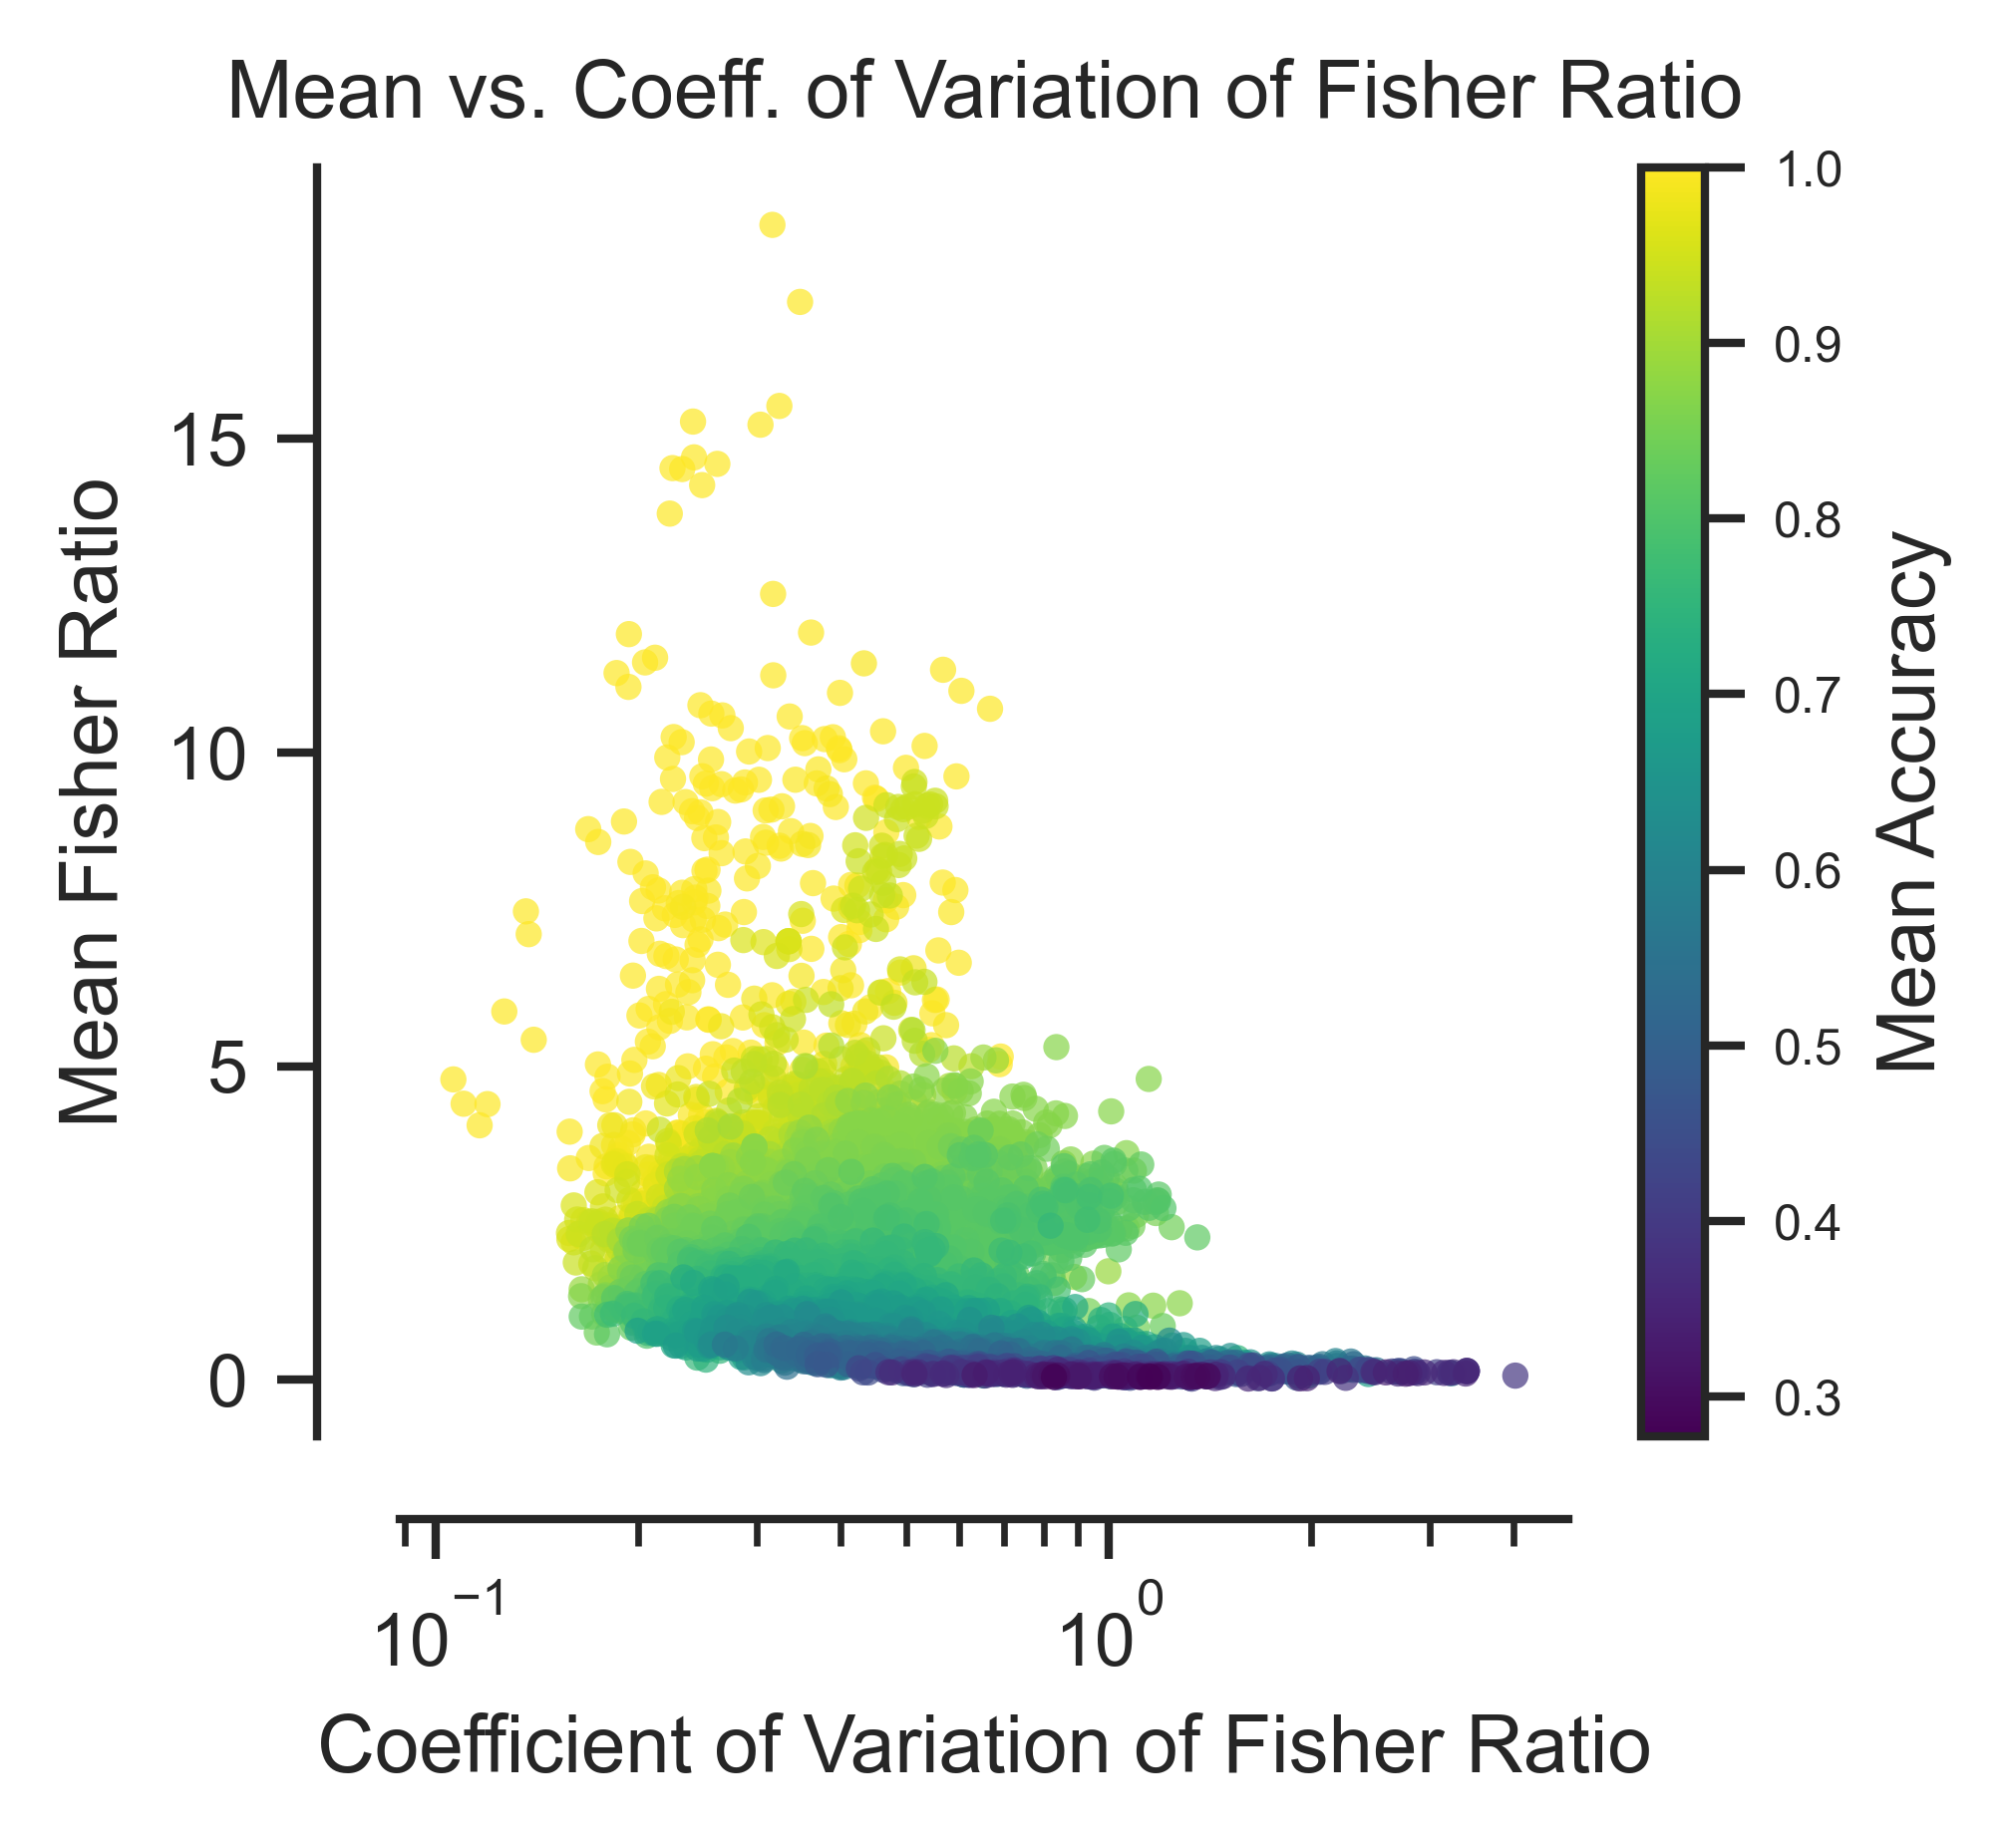

In [57]:
spc.plot_mean_cv('fisher_ratio')
# spc.plot_mean_lda_error('fisher ratio')

# Discussion

## On the Recommended Filter Subsets 

Here we define SPCs in the top percentile (i.e. percentile score of > 99%) as 'high performing', and we define the recommended filter subset as the SPC with the minimum number of unique filters in this set.

For the ranking systems of All-Data Fisher Ratio and Mean Accuracy, we access these recommendations with the following code:

## For the All-Data Fisher Ratio:

In [58]:
hp_spcs = top_fr_d[top_fr_d['pct_lda_score'] > 99]
recc_spc_fr_d = hp_spcs[hp_spcs['n_uniq_fltrs'] == hp_spcs['n_uniq_fltrs'].min()]
recc_spc_fr_d

,lda_score,n_uniq_fltrs,uniq_fltrs,sp_0,sp_1,pct_lda_score,scope
spc_id,,,,,,,
436,15.862124,2,"(F03, F04)",R580,R_650_580,100.0,$FR_{D}$


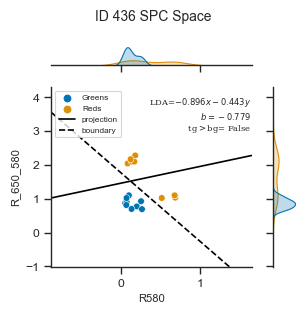

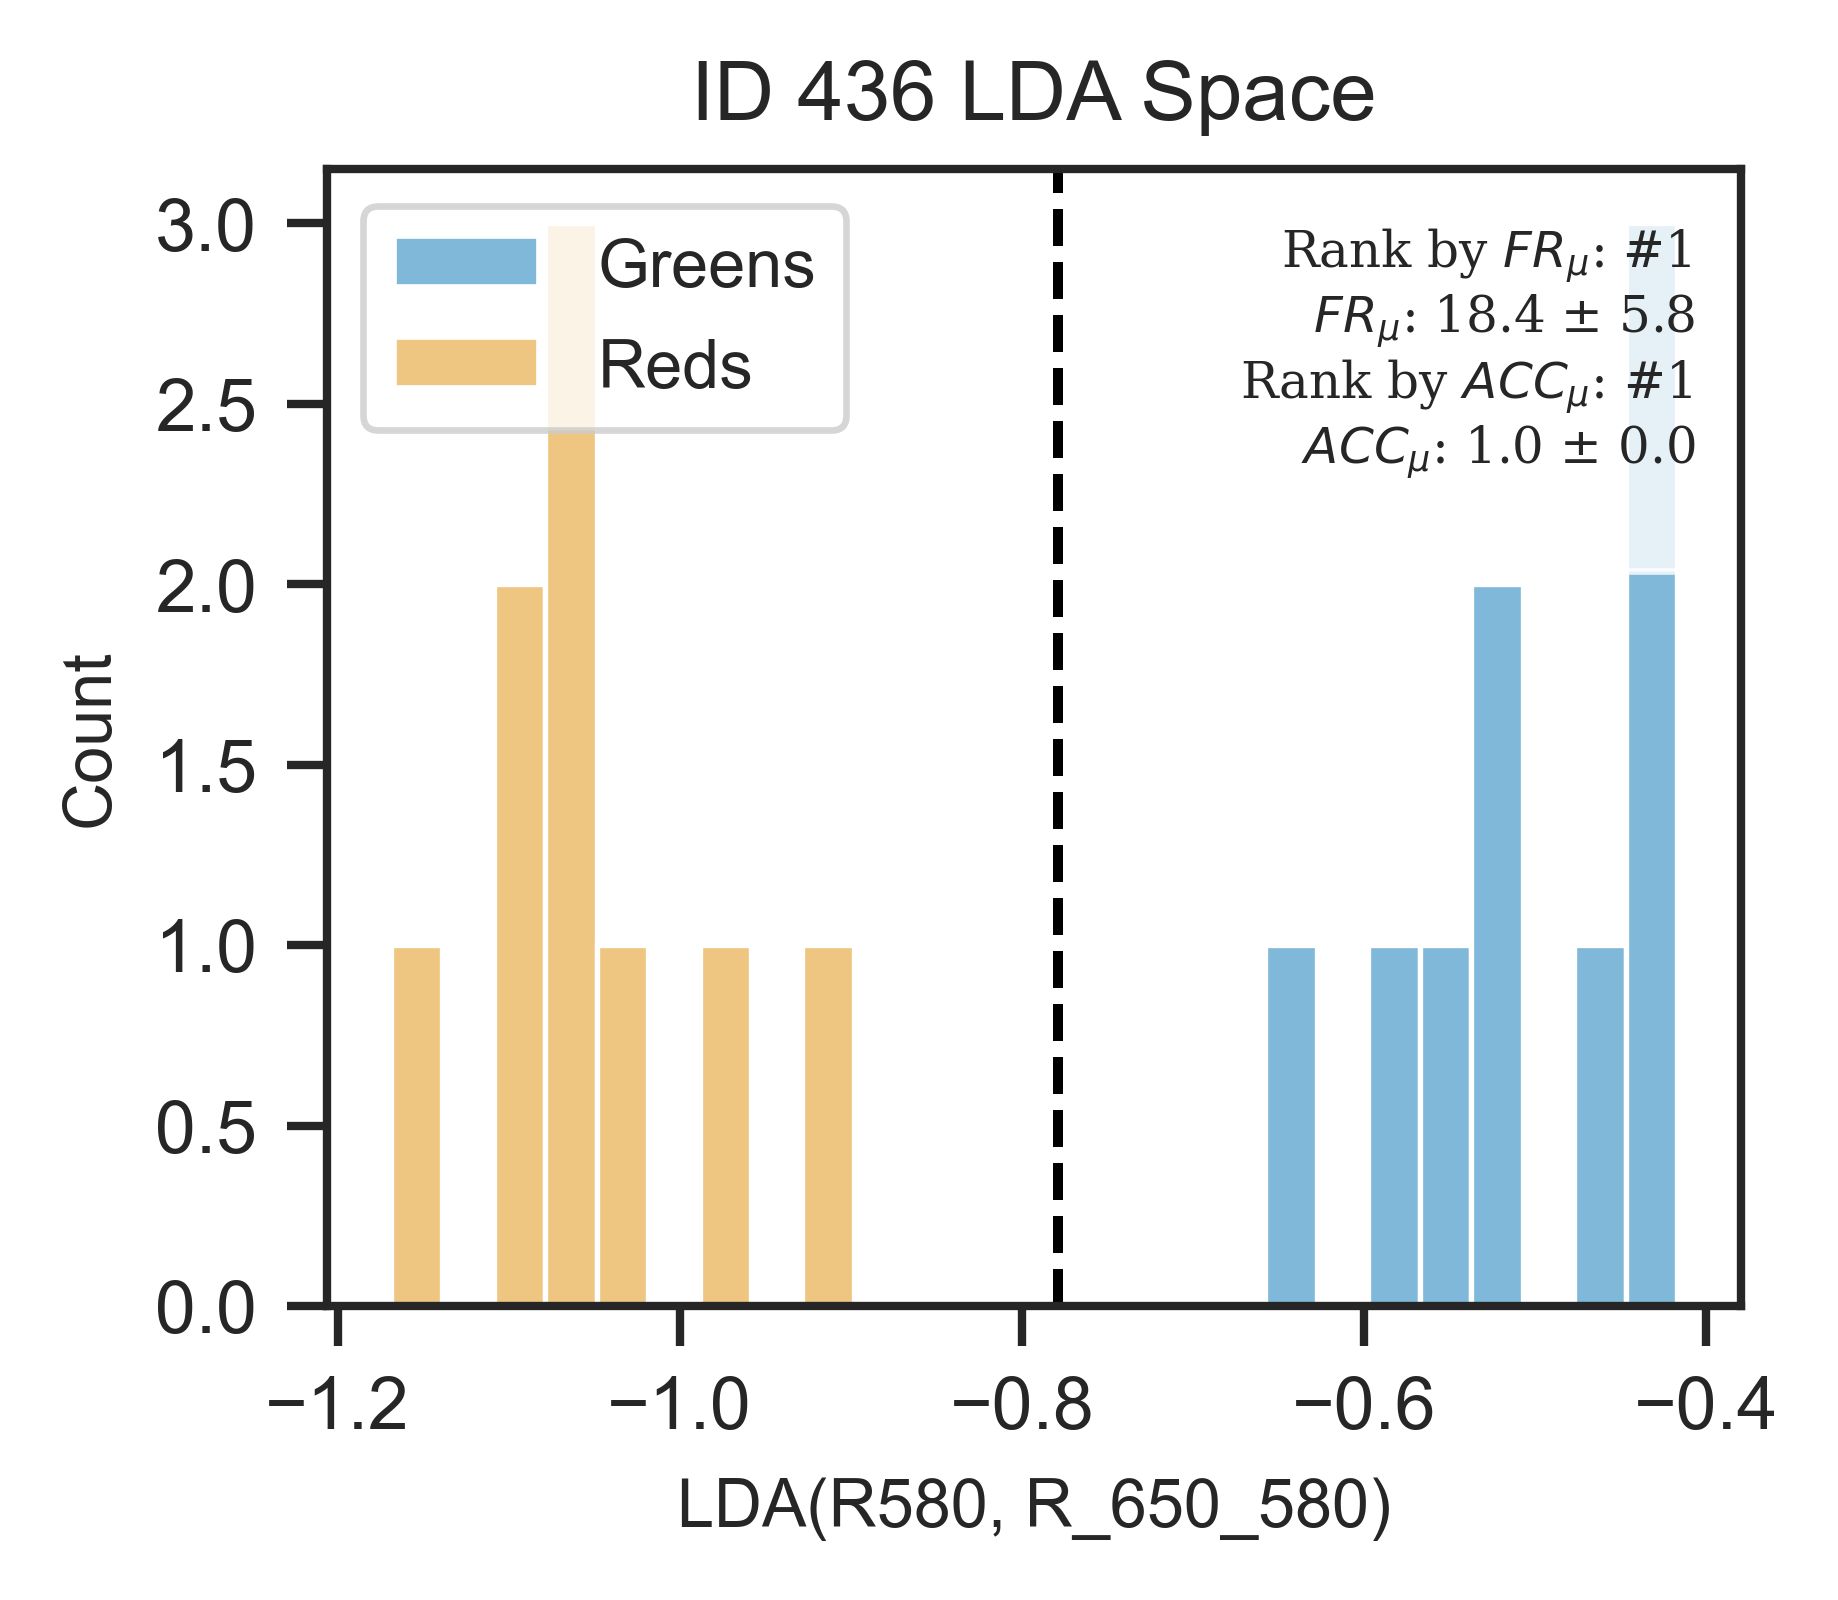

In [59]:
spc.plot_sp_combo(spc_id=recc_spc_fr_d.index[0], spectral_parameters=sps, metric='lda_score', scope='all-data')
spc.plot_spc_lda(spc_id=recc_spc_fr_d.index[0], spectral_parameters=sps, metric='lda_score', scope='all-data')

## For the Mean Accuracy:

In [60]:
# # recommended by ACC_mu
hp_spcs = top_acc_mu[top_acc_mu['pct_lda_acc_1'] > 99]
recc_spc_acc_mu = hp_spcs[hp_spcs['n_uniq_fltrs'] == hp_spcs['n_uniq_fltrs'].min()]
recc_spc_acc_mu

,lda_acc_1,n_uniq_fltrs,uniq_fltrs,sp_0,sp_1,pct_lda_acc_1,scope
spc_id,,,,,,,
29,1.0,2,"(F04, F01)",R440,R_650_440,100.0,$ACC_{\mu}$
226,1.0,2,"(F02, F03)",R500,R_580_500,100.0,$ACC_{\mu}$
233,1.0,2,"(F02, F04)",R500,R_650_500,100.0,$ACC_{\mu}$
429,1.0,2,"(F03, F04)",R580,R_580_650,100.0,$ACC_{\mu}$
436,1.0,2,"(F03, F04)",R580,R_650_580,100.0,$ACC_{\mu}$
623,1.0,2,"(F02, F04)",R650,R_500_650,100.0,$ACC_{\mu}$
630,1.0,2,"(F03, F04)",R650,R_580_650,100.0,$ACC_{\mu}$
636,1.0,2,"(F02, F04)",R650,R_650_500,100.0,$ACC_{\mu}$
637,1.0,2,"(F03, F04)",R650,R_650_580,100.0,$ACC_{\mu}$


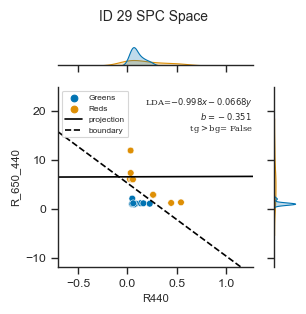

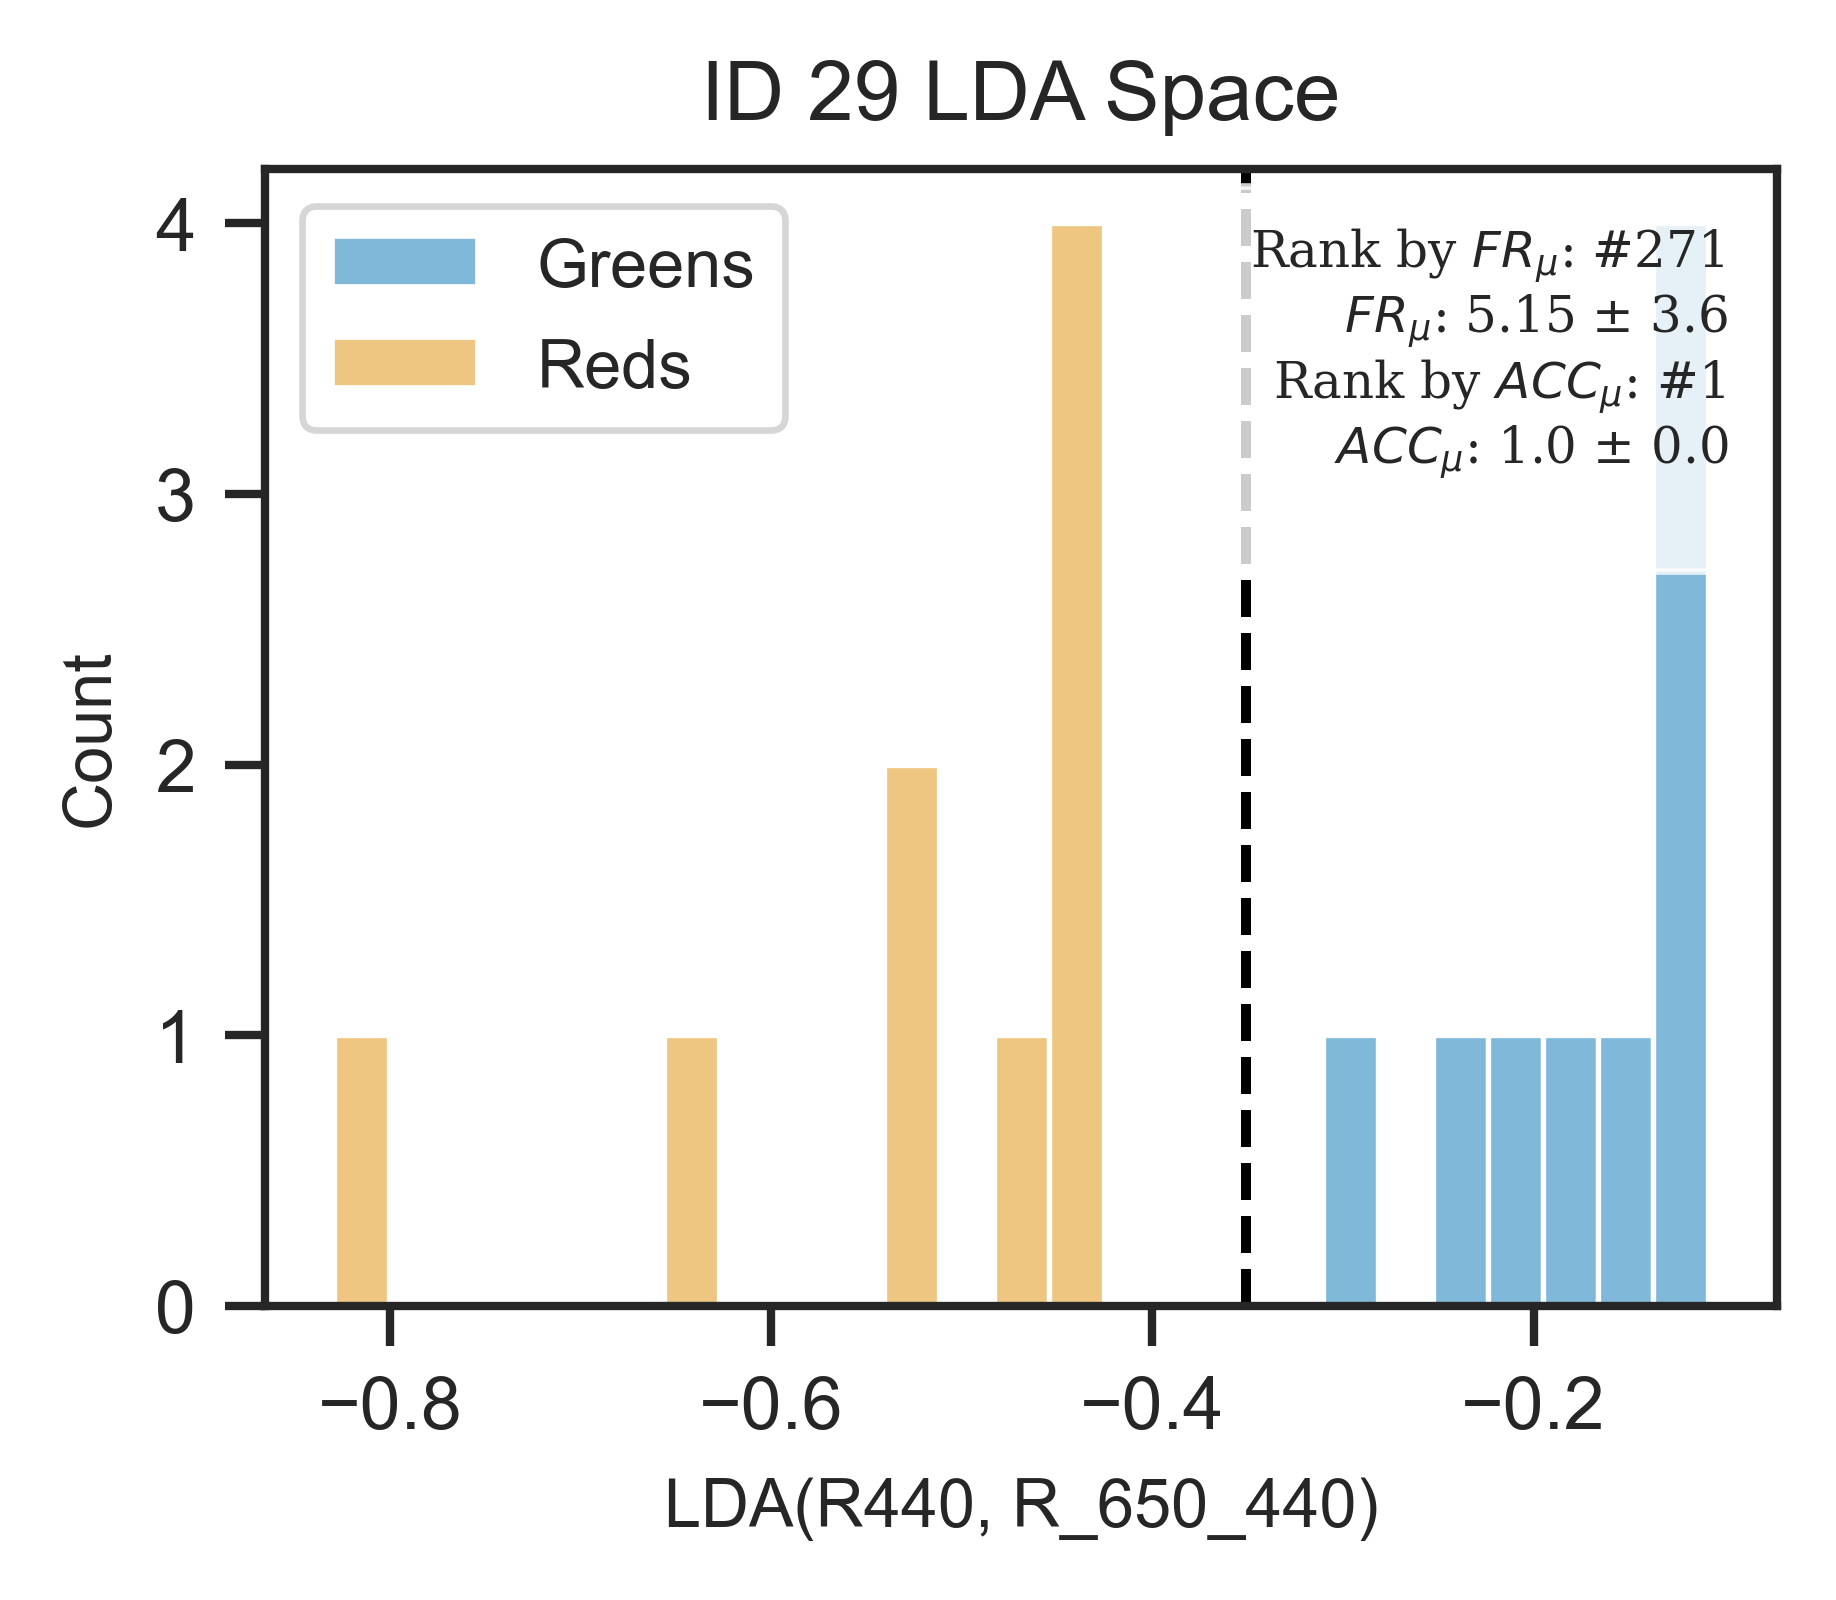

In [61]:
spc.plot_sp_combo(spc_id=recc_spc_acc_mu.index[0], spectral_parameters=sps, metric='lda_acc_1', scope='mean')
spc.plot_spc_lda(spc_id=recc_spc_acc_mu.index[0], spectral_parameters=sps, metric='lda_acc_1', scope='mean')